In [1]:
import pandas as pd               # We use pandas for data analysis and processing.
import requests
import json
from pandas import json_normalize

In [2]:
import numpy as np                # We use numpy for multi-dimensional arrays and mathematical operations.
import seaborn as sns             # We use seaborn for a high-level interface for data visualization.
import matplotlib.pyplot as plt   # We use matplotlib.pyplot for creating plots and graphs.
#%matplotlib inline                # We enable the inline backend for matplotlib in Jupyter notebooks.
sns.set(color_codes=True)         # We configure seaborn to use color codes for enhanced visualization

In [3]:
import math                       # We import the math module for access to mathematical functions.

In [4]:
import warnings
warnings.filterwarnings('ignore') # We can suppress the warnings

In [5]:
import ipywidgets as widgets
from IPython.display import display, clear_output


In [6]:
# API URL'si
url = "https://ws.cso.ie/public/api.restful/PxStat.Data.Cube_API.ReadDataset/ROA04/JSON-stat/1.0/en"

In [7]:
# API'den veri çekmek için GET isteği yapılıyor
res = requests.get(url)

# Eğer istek başarılıysa (HTTP 200), veriyi al
if res.status_code == 200:
    data = res.json()  # JSON formatındaki veriyi Python sözlüğüne dönüştürür
    print("Response=",res.status_code,"\n")
    print("Response successful")
else:
    print("API'den veri çekilemedi. Hata kodu:", response.status_code)

Response= 200 

Response successful


In [8]:
data.keys()

dict_keys(['dataset'])

In [9]:
data['dataset']

{'dimension': {'STATISTIC': {'label': 'Statistic',
   'category': {'index': {'ROA04C1': 0, 'ROA04C2': 1},
    'label': {'ROA04C1': 'Full Driving Licences',
     'ROA04C2': 'Learner Permit Driving Licences'},
    'unit': {'ROA04C1': {'base': 'Number'}, 'ROA04C2': {'base': 'Number'}}}},
  'TLIST(A1)': {'label': 'Year',
   'category': {'index': {'2009': 0,
     '2010': 1,
     '2011': 2,
     '2012': 3,
     '2013': 4,
     '2014': 5,
     '2015': 6,
     '2016': 7,
     '2017': 8,
     '2018': 9,
     '2019': 10,
     '2020': 11,
     '2021': 12,
     '2022': 13},
    'label': {'2009': '2009',
     '2010': '2010',
     '2011': '2011',
     '2012': '2012',
     '2013': '2013',
     '2014': '2014',
     '2015': '2015',
     '2016': '2016',
     '2017': '2017',
     '2018': '2018',
     '2019': '2019',
     '2020': '2020',
     '2021': '2021',
     '2022': '2022'}}},
  'C02076V03371': {'label': 'Age Group',
   'category': {'index': {'-': 0,
     '336': 1,
     '3401': 2,
     '385': 3,
    

In [10]:
data['dataset'].keys()

dict_keys(['dimension', 'label', 'source', 'updated', 'value'])

In [11]:
data['dataset']['value']

[2362292.0,
 1294008.0,
 1068284.0,
 3.0,
 1.0,
 2.0,
 46258.0,
 28631.0,
 17627.0,
 132124.0,
 71179.0,
 60945.0,
 249341.0,
 127963.0,
 121378.0,
 566068.0,
 296445.0,
 269623.0,
 500679.0,
 267591.0,
 233088.0,
 405903.0,
 226276.0,
 179627.0,
 291517.0,
 171512.0,
 120005.0,
 134121.0,
 81528.0,
 52593.0,
 36278.0,
 22882.0,
 13396.0,
 2375171.0,
 1292281.0,
 1082890.0,
 0.0,
 0.0,
 0.0,
 41718.0,
 25845.0,
 15873.0,
 126959.0,
 68734.0,
 58225.0,
 241544.0,
 123865.0,
 117679.0,
 572293.0,
 297541.0,
 274752.0,
 504463.0,
 267944.0,
 236519.0,
 409716.0,
 225584.0,
 184132.0,
 297029.0,
 172528.0,
 124501.0,
 141722.0,
 85394.0,
 56328.0,
 39727.0,
 24846.0,
 14881.0,
 2395131.0,
 1296193.0,
 1098938.0,
 0.0,
 0.0,
 0.0,
 39488.0,
 24301.0,
 15187.0,
 121162.0,
 65881.0,
 55281.0,
 234366.0,
 120376.0,
 113990.0,
 575269.0,
 297384.0,
 277885.0,
 512629.0,
 271109.0,
 241520.0,
 415673.0,
 226358.0,
 189315.0,
 304716.0,
 174972.0,
 129744.0,
 148759.0,
 88973.0,
 59786.0,
 43069.

In [12]:
data['dataset']['label']

'Current Full and Learner Permit Driving Licences'

In [13]:
data['dataset']['dimension'].keys()

dict_keys(['STATISTIC', 'TLIST(A1)', 'C02076V03371', 'C02199V02655', 'role', 'id', 'size'])

In [14]:
# Anahtarları yinelemeli olarak bulan fonksiyon
def find_keys(data, path=None):
    if path is None:
        path = []
    if isinstance(data, dict):
        for k, v in data.items():
            yield path + [k]
            yield from find_keys(v, path + [k])
    elif isinstance(data, list):
        for item in data:
            yield from find_keys(item, path + ["list-item"])

# Fonksiyonu test edelim
keys_list = list(find_keys(data))
for key_path in keys_list:
    print(" -> ".join(key_path))

dataset
dataset -> dimension
dataset -> dimension -> STATISTIC
dataset -> dimension -> STATISTIC -> label
dataset -> dimension -> STATISTIC -> category
dataset -> dimension -> STATISTIC -> category -> index
dataset -> dimension -> STATISTIC -> category -> index -> ROA04C1
dataset -> dimension -> STATISTIC -> category -> index -> ROA04C2
dataset -> dimension -> STATISTIC -> category -> label
dataset -> dimension -> STATISTIC -> category -> label -> ROA04C1
dataset -> dimension -> STATISTIC -> category -> label -> ROA04C2
dataset -> dimension -> STATISTIC -> category -> unit
dataset -> dimension -> STATISTIC -> category -> unit -> ROA04C1
dataset -> dimension -> STATISTIC -> category -> unit -> ROA04C1 -> base
dataset -> dimension -> STATISTIC -> category -> unit -> ROA04C2
dataset -> dimension -> STATISTIC -> category -> unit -> ROA04C2 -> base
dataset -> dimension -> TLIST(A1)
dataset -> dimension -> TLIST(A1) -> label
dataset -> dimension -> TLIST(A1) -> category
dataset -> dimension 

In [15]:
# Boyutlar ve etiketler
dimensions = data['dataset']['dimension']
values = data['dataset']['value']  # Değerlerin listesi

# DataFrame sütunlarını oluşturmak için boyutlardan indeks ve etiketleri çıkar
stats = list(dimensions['STATISTIC']['category']['label'].values())
years = list(dimensions['TLIST(A1)']['category']['label'].values())
age_groups = list(dimensions['C02076V03371']['category']['label'].values())
sex = list(dimensions['C02199V02655']['category']['label'].values())
#values=data['dataset']['value']


In [16]:
# Converting each string in the list to an integer
int_years = [int(year) for year in years]
int_years

[2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2020,
 2021,
 2022]

In [17]:
# JSON verisini düz bir tabloya dönüştüren fonksiyon
#def process_json_data(data):
# Veri çerçevesini oluşturacak verileri toplayacak listeler
stats_list, years_list ,int_years_list, age_groups_list, sex_list = [], [], [], [], []

# JSON-stat değerlerinin çok boyutlu dizilimini düzleştirmek için her bir boyut boyunca döngü
for stat_label in stats:
    for year in int_years:
        for age_label in age_groups:
            for sex_label in sex:
                stats_list.append(stat_label)
                int_years_list.append(year)
                age_groups_list.append(age_label)
                sex_list.append(sex_label)

# DataFrame oluştur
df = pd.DataFrame({
    'Statistic': stats_list,
    'Year': int_years_list,
    'Age Group': age_groups_list,
    'Sex': sex_list,
    'Value': values
})
df
# Fonksiyonu çağırarak verileri işle ve DataFrame oluştur
#df = process_json_data(data)
#df

,Statistic,Year,Age Group,Sex,Value
0,Full Driving Licences,2009,All ages,Both sexes,2362292.0
1,Full Driving Licences,2009,All ages,Male,1294008.0
2,Full Driving Licences,2009,All ages,Female,1068284.0
3,Full Driving Licences,2009,Under 17 years,Both sexes,3.0
4,Full Driving Licences,2009,Under 17 years,Male,1.0
...,...,...,...,...,...
919,Learner Permit Driving Licences,2022,70 - 79 years,Male,523.0
920,Learner Permit Driving Licences,2022,70 - 79 years,Female,1111.0
921,Learner Permit Driving Licences,2022,80 years and over,Both sexes,236.0
922,Learner Permit Driving Licences,2022,80 years and over,Male,64.0


In [18]:
# # JSON verisini düz bir tabloya dönüştüren fonksiyon
# def process_json_data(data):
#     # Veri çerçevesini oluşturacak verileri toplayacak listeler
#     stats_list, years_list ,int_years_list, age_groups_list, sex_list = [], [], [], [], []

#     # JSON-stat değerlerinin çok boyutlu dizilimini düzleştirmek için her bir boyut boyunca döngü
#     for stat_label in stats:
#         for year in int_years:
#             for age_label in age_groups:
#                 for sex_label in sex:
#                     stats_list.append(stat_label)
#                     int_years_list.append(year)
#                     age_groups_list.append(age_label)
#                     sex_list.append(sex_label)
                    
#     # DataFrame oluştur
#     df = pd.DataFrame({
#         'Statistic': stats_list,
#         'Year': int_years_list,
#         'Age Group': age_groups_list,
#         'Sex': sex_list,
#         'Value': values
#     })
    
#     return df
# # Fonksiyonu çağırarak verileri işle ve DataFrame oluştur
# df = process_json_data(data)
# df

In [19]:
df2=pd.read_csv("People_with_a_driving_licence_22122023_160245.csv",sep=';') #We read the second data set with pandas
#veri setimiz noktali virgul ile ayrildigi icin sep parametresini ';' olarak ayarliyoruz

In [20]:
df2.head()

,Periods,Age driving license holder,Passenger car driving licence total,Passenger car licence excl. trailer,Passenger car licence incl. trailer
0,2014,Total,2381440.0,1185966.0,1195474.0
1,2014,16 to 17 years,3230.0,3230.0,NaN
2,2014,18 to 19 years,41200.0,40467.0,733.0
3,2014,20 to 24 years,163919.0,155859.0,8060.0
4,2014,25 to 29 years,172310.0,157944.0,14366.0


In [21]:
df2.isnull().sum()                        # We count the number of null values in each column of the dataframe

Periods                                 0
Age driving license holder              1
Passenger car driving licence total     1
Passenger car licence excl. trailer     1
Passenger car licence incl. trailer    11
dtype: int64

In [22]:
df2.duplicated().sum()                    # We count the total number of duplicated rows in the dataframe

0

In [23]:
missing_df2 = df2[df2.isna().any(axis=1)] # We create a new dataframe containing only the rows with missing data.
missing_df2 # We display the dataframe with missing values.

,Periods,Age driving license holder,Passenger car driving licence total,Passenger car licence excl. trailer,Passenger car licence incl. trailer
1,2014,16 to 17 years,3230.0,3230.0,NaN
13,2015,16 to 17 years,3869.0,3869.0,NaN
25,2016,16 to 17 years,4252.0,4252.0,NaN
37,2017,16 to 17 years,4383.0,4383.0,NaN
49,2018,16 to 17 years,4736.0,4736.0,NaN
61,2019,16 to 17 years,4444.0,4444.0,NaN
73,2020,16 to 17 years,4358.0,4358.0,NaN
85,2021,16 to 17 years,2744.0,2744.0,NaN
97,2022,16 to 17 years,2220.0,2220.0,NaN
109,2023,16 to 17 years,3050.0,3050.0,NaN


In [24]:
# We drop the specified columns from the dataframe and apply changes directly with inplace=True.
df2.drop(columns=["Passenger car licence excl. trailer"], inplace=True)
df2.drop(columns=["Passenger car licence incl. trailer"], inplace=True)
df2 = df2.drop(index=120)
df2

,Periods,Age driving license holder,Passenger car driving licence total
0,2014,Total,2381440.0
1,2014,16 to 17 years,3230.0
2,2014,18 to 19 years,41200.0
3,2014,20 to 24 years,163919.0
4,2014,25 to 29 years,172310.0
...,...,...,...
115,2023,50 to 59 years,504071.0
116,2023,60 to 64 years,244904.0
117,2023,65 to 69 years,209807.0
118,2023,70 to 74 years,186232.0


In [25]:
df2.isnull().sum() # We count the number of null values in each column of the dataframe

Periods                                0
Age driving license holder             0
Passenger car driving licence total    0
dtype: int64

In [26]:
df2 = df2.rename(columns={"Periods":"Year",
                        "Age driving license holder":"Age Group",
                        "Passenger car driving licence total": "Value"}) # We rename 'VALUE' to 'Value' to match the naming style of other columns.

In [27]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Year       120 non-null    object 
 1   Age Group  120 non-null    object 
 2   Value      120 non-null    float64
dtypes: float64(1), object(2)
memory usage: 2.9+ KB


In [28]:
df["Value"] = df["Value"].astype(int)
#df2['Value'] = df2['Value'].str.replace(',', '.').astype(float)
df2["Year"] = df2["Year"].astype(int)
df2["Value"] = df2["Value"].astype(int)
print("Ireland dtypes:\n",df.dtypes,"\n")
print("Netherlands dtypes:\n",df2.dtypes)

Ireland dtypes:
 Statistic    object
Year          int64
Age Group    object
Sex          object
Value         int32
dtype: object 

Netherlands dtypes:
 Year          int32
Age Group    object
Value         int32
dtype: object


In [29]:
df = df[df["Sex"] == "Both sexes"].reset_index(drop=True)
df.drop(columns=["Sex"], inplace=True)
df

,Statistic,Year,Age Group,Value
0,Full Driving Licences,2009,All ages,2362292
1,Full Driving Licences,2009,Under 17 years,3
2,Full Driving Licences,2009,17 - 20 years,46258
3,Full Driving Licences,2009,21 - 24 years,132124
4,Full Driving Licences,2009,25 - 29 years,249341
...,...,...,...,...
303,Learner Permit Driving Licences,2022,40 - 49 years,38111
304,Learner Permit Driving Licences,2022,50 - 59 years,15412
305,Learner Permit Driving Licences,2022,60 - 69 years,5125
306,Learner Permit Driving Licences,2022,70 - 79 years,1634


In [30]:
df["Statistic"].unique()

array(['Full Driving Licences', 'Learner Permit Driving Licences'],
      dtype=object)

In [31]:
# Yıl ve yaş grubuna göre gruplandır ve 'Value' sütunu için toplam al
total_licences = df.groupby(["Year", "Age Group"]).sum().reset_index()

# Yeni bir 'Statistic' sütunu ekle ve 'Total Licences' olarak adlandır
total_licences["Statistic"] = "Total Licences"

# Bu toplamı orijinal df DataFrame'ine ekle
df = pd.concat([df, total_licences], ignore_index=True)
df = df[(df["Year"] >= 2014) & (df["Statistic"] == "Total Licences")].reset_index(drop=True)
df.drop(columns=["Statistic"], inplace=True)
df

,Year,Age Group,Value
0,2014,17 - 20 years,87492
1,2014,21 - 24 years,150032
2,2014,25 - 29 years,245595
3,2014,30 - 39 years,629313
4,2014,40 - 49 years,568308
...,...,...,...
94,2022,60 - 69 years,452487
95,2022,70 - 79 years,273037
96,2022,80 years and over,94761
97,2022,All ages,3325487


In [32]:
df2 = df2[(df2["Year"] <= 2022)].reset_index(drop=True)
df2

,Year,Age Group,Value
0,2014,Total,2381440
1,2014,16 to 17 years,3230
2,2014,18 to 19 years,41200
3,2014,20 to 24 years,163919
4,2014,25 to 29 years,172310
...,...,...,...
103,2022,50 to 59 years,510566
104,2022,60 to 64 years,240066
105,2022,65 to 69 years,206217
106,2022,70 to 74 years,186056


In [33]:
print("Ireland age group unique:\n",f"Total= {df['Age Group'].nunique()}\n",df["Age Group"].unique(),"\n")
print("Netherlands age group unique:\n",f"Total= {df2['Age Group'].nunique()}\n",df2["Age Group"].unique(),"\n")

Ireland age group unique:
 Total= 11
 ['17 - 20 years' '21 - 24 years' '25 - 29 years' '30 - 39 years'
 '40 - 49 years' '50 - 59 years' '60 - 69 years' '70 - 79 years'
 '80 years and over' 'All ages' 'Under 17 years'] 

Netherlands age group unique:
 Total= 12
 ['Total' '16 to 17 years' '18 to 19 years' '20 to 24 years'
 '25 to 29 years' '30 to 39 years' '40 to 49 years' '50 to 59 years'
 '60 to 64 years' '65 to 69 years' '70 to 74 years' '75 years or older'] 



In [34]:
df2['Age Group'] = df2['Age Group'].replace({"16 to 17 years": "Under 17 years","Total":"All ages"})
df2['Age Group'] = df2['Age Group'].str.replace("to","-")
df2['Age Group'] = df2['Age Group'].str.replace("or older","and over")

In [35]:
# Adım 1: İlgili yaş gruplarını filtrele
age_groups_to_combine = df['Age Group'].isin(['17 - 20 years', '21 - 24 years'])
age_groups_to_combine2 = df['Age Group'].isin(['70 - 79 years', '80 years and over'])
# Adım 2: Yıl bazında bu grupların 'Value' değerlerini topla
combined_values = df[age_groups_to_combine].groupby("Year")["Value"].sum().reset_index()
combined_values2 = df[age_groups_to_combine2].groupby("Year")["Value"].sum().reset_index()
# Adım 3: 'Age Group' sütunu ekleyip '60 - 69 years' olarak ayarla
combined_values['Age Group'] = "17 - 24 years"
combined_values2['Age Group'] = "70 years and over"
# Adım 4: Orijinal verileri kaldır (isteğe bağlı)
df = df[~age_groups_to_combine]
df = df[~age_groups_to_combine2]
# Adım 5: Yeni değerleri ekleyin
df = pd.concat([df, combined_values, combined_values2], ignore_index=True)

# DataFrame'i yeniden sıralayın (isteğe bağlı)
df = df.sort_values(by=['Year', 'Age Group']).reset_index(drop=True)

In [36]:
# Adım 1: İlgili yaş gruplarını filtrele
age_groups_to_combine21 = df2['Age Group'].isin(['60 - 64 years', '65 - 69 years'])
age_groups_to_combine22 = df2['Age Group'].isin(['18 - 19 years', '20 - 24 years'])
age_groups_to_combine23 = df2['Age Group'].isin(['70 - 74 years', '75 years and over'])
# Adım 2: Yıl bazında bu grupların 'Value' değerlerini topla
combined_values21 = df2[age_groups_to_combine21].groupby("Year")["Value"].sum().reset_index()
combined_values22 = df2[age_groups_to_combine22].groupby("Year")["Value"].sum().reset_index()
combined_values23 = df2[age_groups_to_combine23].groupby("Year")["Value"].sum().reset_index()
# Adım 3: 'Age Group' sütunu ekleyip '60 - 69 years' olarak ayarla
combined_values21['Age Group'] = "60 - 69 years"
combined_values22['Age Group'] = "17 - 24 years"
combined_values23['Age Group'] = "70 years and over"
# Adım 4: Orijinal verileri kaldır (isteğe bağlı)
df2 = df2[~age_groups_to_combine21]
df2 = df2[~age_groups_to_combine22]
df2 = df2[~age_groups_to_combine23]
# Adım 5: Yeni değerleri ekleyin
df2 = pd.concat([df2, combined_values21,combined_values22,combined_values23], ignore_index=True)

# DataFrame'i yeniden sıralayın (isteğe bağlı)
df2 = df2.sort_values(by=['Year', 'Age Group']).reset_index(drop=True)

In [37]:
print("Ireland age group unique:\n",f"Total= {df['Age Group'].nunique()}\n",df["Age Group"].unique(),"\n")
print("Netherlands age group unique:\n",f"Total= {df2['Age Group'].nunique()}\n",df2["Age Group"].unique(),"\n")

Ireland age group unique:
 Total= 9
 ['17 - 24 years' '25 - 29 years' '30 - 39 years' '40 - 49 years'
 '50 - 59 years' '60 - 69 years' '70 years and over' 'All ages'
 'Under 17 years'] 

Netherlands age group unique:
 Total= 9
 ['17 - 24 years' '25 - 29 years' '30 - 39 years' '40 - 49 years'
 '50 - 59 years' '60 - 69 years' '70 years and over' 'All ages'
 'Under 17 years'] 



In [38]:
Ireland = df
Netherlands = df2

In [39]:
Ireland

,Year,Age Group,Value
0,2014,17 - 24 years,237524
1,2014,25 - 29 years,245595
2,2014,30 - 39 years,629313
3,2014,40 - 49 years,568308
4,2014,50 - 59 years,454946
...,...,...,...
76,2022,50 - 59 years,601477
77,2022,60 - 69 years,452487
78,2022,70 years and over,367798
79,2022,All ages,3325487


In [40]:
Netherlands

,Year,Age Group,Value
0,2014,17 - 24 years,205119
1,2014,25 - 29 years,172310
2,2014,30 - 39 years,356824
3,2014,40 - 49 years,494320
4,2014,50 - 59 years,489610
...,...,...,...
76,2022,50 - 59 years,510566
77,2022,60 - 69 years,446283
78,2022,70 years and over,408747
79,2022,All ages,2524888


In [41]:
total_rows = df.shape[0]                 # We assign the number of rows to "total_rows"
total_columns = df.shape[1]              # We assign the number of columns to "total_columns"
total_rows2 = df2.shape[0]                 # We assign the number of rows to "total_rows"
total_columns2 = df2.shape[1]              # We assign the number of columns to "total_columns"
print(f"Ireland Total Rows= {total_rows}")       # We print the total number of rows
print(f"Ireland Total Columns= {total_columns}") # We print the total number of columns
print(f"Netherlands Total Rows= {total_rows2}")       # We print the total number of rows
print(f"Netherlands Total Columns= {total_columns2}") # We print the total number of columns

Ireland Total Rows= 81
Ireland Total Columns= 3
Netherlands Total Rows= 81
Netherlands Total Columns= 3


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Year       81 non-null     int64 
 1   Age Group  81 non-null     object
 2   Value      81 non-null     int32 
dtypes: int32(1), int64(1), object(1)
memory usage: 1.7+ KB


In [43]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Year       81 non-null     int32 
 1   Age Group  81 non-null     object
 2   Value      81 non-null     int32 
dtypes: int32(2), object(1)
memory usage: 1.4+ KB


In [44]:
# pd.set_option('display.max_rows', None)  # Tüm satırları göstermek için
# print(df)
# pd.reset_option('display.max_rows')

with pd.option_context('display.max_rows', None):
    print(df,"\n")
with pd.option_context('display.max_rows', None):
    print(df2)

    Year          Age Group    Value
0   2014      17 - 24 years   237524
1   2014      25 - 29 years   245595
2   2014      30 - 39 years   629313
3   2014      40 - 49 years   568308
4   2014      50 - 59 years   454946
5   2014      60 - 69 years   340771
6   2014  70 years and over   232928
7   2014           All ages  2710664
8   2014     Under 17 years     1279
9   2015      17 - 24 years   238607
10  2015      25 - 29 years   240823
11  2015      30 - 39 years   632343
12  2015      40 - 49 years   582279
13  2015      50 - 59 years   468059
14  2015      60 - 69 years   352209
15  2015  70 years and over   248461
16  2015           All ages  2764069
17  2015     Under 17 years     1288
18  2016      17 - 24 years   239640
19  2016      25 - 29 years   235873
20  2016      30 - 39 years   637360
21  2016      40 - 49 years   597842
22  2016      50 - 59 years   479959
23  2016      60 - 69 years   363360
24  2016  70 years and over   265128
25  2016           All ages  2820528
2

In [45]:
print(df.describe(),"\n")
print(df2.describe())

              Year         Value
count    81.000000  8.100000e+01
mean   2018.000000  6.614900e+05
std       2.598076  8.494945e+05
min    2014.000000  1.243000e+03
25%    2016.000000  2.396400e+05
50%    2018.000000  3.884350e+05
75%    2020.000000  6.230160e+05
max    2022.000000  3.325487e+06 

              Year         Value
count    81.000000  8.100000e+01
mean   2018.000000  5.462181e+05
std       2.598076  6.964024e+05
min    2014.000000  2.220000e+03
25%    2016.000000  2.063670e+05
50%    2018.000000  3.727390e+05
75%    2020.000000  4.641840e+05
max    2022.000000  2.524888e+06


In [46]:
#df.to_csv('Ireland.csv', index=False)
#df2.to_csv('Netherlands.csv', index=False)

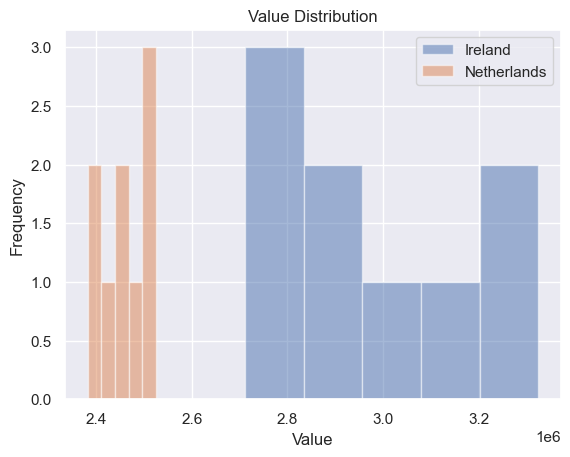

In [47]:
# Histograms for the 'Value' column in both datasets
all_ages=df[df["Age Group"]=="All ages"]
all_ages2=df2[df2["Age Group"]=="All ages"]
plt.hist(all_ages["Value"],bins=5, alpha=0.5, label='Ireland')
plt.hist(all_ages2["Value"],bins=5, alpha=0.5, label='Netherlands')
plt.legend()
plt.title('Value Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

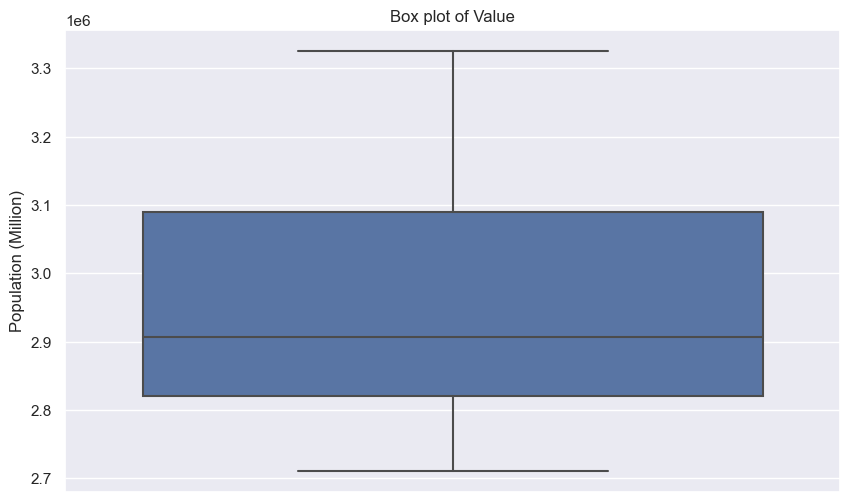

In [48]:
# If we need to focus on the data starting from the year 2010, we can filter it with the following line.
# BothSexes_AllAges = BothSexes_AllAges[BothSexes_AllAges["Year"] >= 2010]

# We're plotting a boxplot for the 'Value' variable, which represents the annual total population.
plt.figure(figsize=(10, 6))  # We set the figure size to 10 by 6 inches for better visibility.
sns.boxplot(y=all_ages["Value"])  # We use seaborn's boxplot function, setting 'y' to the 'Value' column.
plt.title("Box plot of Value")  # We add a title to the plot.
plt.ylabel("Population (Million)")  # We label the y-axis as 'Population (Million)'.
plt.show()  # We display the plot.

In [49]:
# We exclude the 'Both sexes' category for the selected year and age group.
df_filtered= df[(df["Year"] == 2022) & (df["Age Group"] == "All ages")]
df_filtered2= df2[(df2["Year"] == 2022) & (df2["Age Group"] == "All ages")]
# We calculate the total 'Value' for each sex within the selected year.
combined_df = pd.concat([df_filtered, df_filtered2], axis=0)
combined_df['Country'] = ['Ireland'] * len(df_filtered) + ['Netherlands'] * len(df_filtered2)
combined_df

,Year,Age Group,Value,Country
79,2022,All ages,3325487,Ireland
79,2022,All ages,2524888,Netherlands


In [50]:
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output

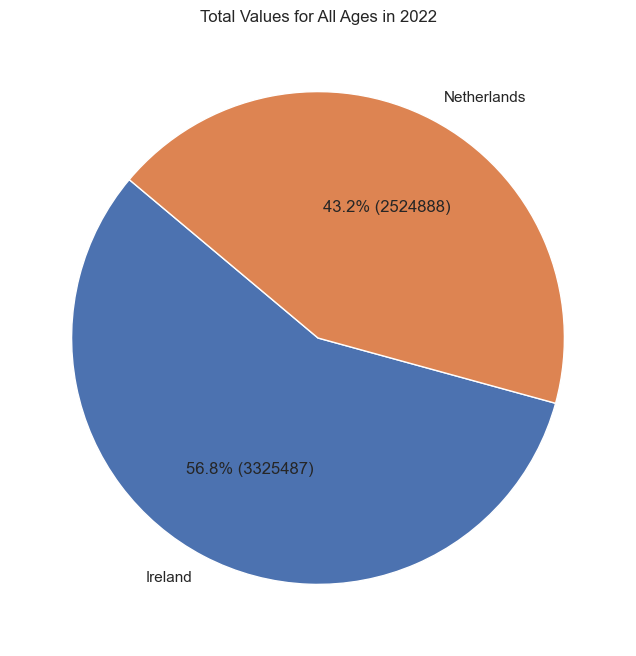

In [51]:
ireland_total = df[(df["Year"] == 2022) & (df["Age Group"] == "All ages")]["Value"].sum()
netherlands_total = df2[(df2["Year"] == 2022) & (df2["Age Group"] == "All ages")]["Value"].sum()
values = [ireland_total, netherlands_total]
labels = ['Ireland', 'Netherlands']
total = sum(values)

plt.figure(figsize=(8, 8))
#plt.pie(values, labels=labels, autopct=autopct_format(values), startangle=140)
plt.pie(values, labels=labels,
        autopct=lambda pct: '{:.1f}% ({:.0f})'.format(pct, pct * total / 100),startangle=140)
plt.title('Total Values for All Ages in 2022')
plt.show()

In [52]:
filtered_data = df[(df['Year'] == year) & (df["Age Group"]=="All ages")]
values = filtered_data.iloc[0,1:].tolist()
values

['All ages', 3325487]

Dropdown(description='Year:', options=(2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022), value=2014)

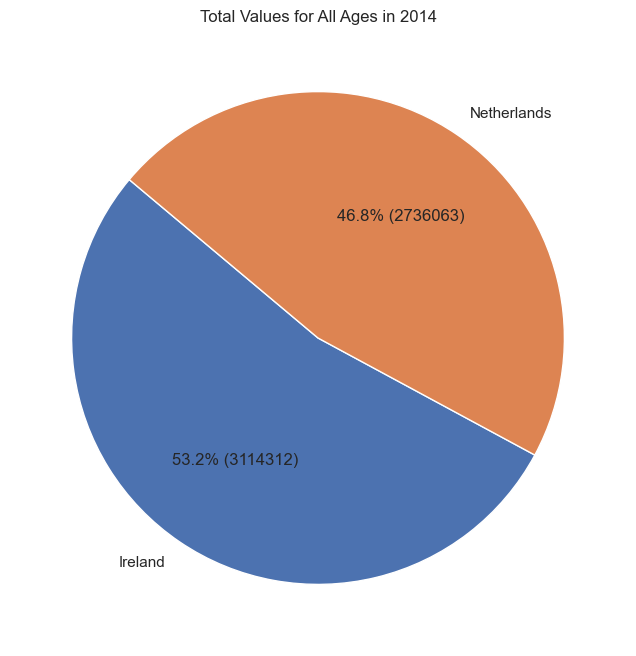

In [53]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Yıllara göre toplam değerleri hesaplayın
ireland_totals = all_ages.groupby('Year')['Value'].sum()
netherlands_totals = all_ages2.groupby('Year')['Value'].sum()

# Yılları ve toplam değerleri içeren bir DataFrame oluşturun
df_totals = pd.DataFrame({
    'Year': ireland_totals.index,
    'Ireland': ireland_totals.values,
    'Netherlands': netherlands_totals.values
})

# Yıllar için dropdown widget'ını oluştur
year_dropdown_pie_chart = widgets.Dropdown(
    options=df_totals['Year'].unique().tolist(),
    description='Year:',
    disabled=False,
)

# Pie chart çizdirme fonksiyonu
def plot_pie_chart(year):
    filtered_data = df_totals[df_totals['Year'] == year]
    values = filtered_data.iloc[0, 1:].tolist()
    labels = filtered_data.columns[1:].tolist()
    plt.figure(figsize=(8, 8))
    #plt.pie(values, labels=labels,colors = ['green', 'darkorange'], autopct='%1.1f%%', startangle=140)
    plt.pie(values, labels=labels,
        autopct=lambda pct: '{:.1f}% ({:.0f})'.format(pct, pct * total / 100),startangle=140)
    plt.title(f'Total Values for All Ages in {year}')
    plt.show()

# Dropdown değiştiğinde çalışacak fonksiyon
def on_year_change(change):
    clear_output(wait=True)
    display(year_dropdown)
    plot_pie_chart(change.new)

# Dropdown widget'ını göster ve callback fonksiyonunu bağla
display(year_dropdown_pie_chart)
year_dropdown_pie_chart.observe(on_year_change, names='value')

# İlk pie chart'ı varsayılan yıl için çiz
plot_pie_chart(df_totals['Year'].iloc[0])


In [54]:
# plt.figure(figsize=(10, 6)) # Set the figure size for the scatter plot


# # Create a scatter plot with 'Age Group' on the x-axis and 'Value' on the y-axis
# sns.scatterplot(x=df['Age Group'], y=df['Value'])

# # Calculate the rounded minimum value for y-ticks based on the filtered data
# # Multiply by 2 and divide by 2 for rounding to the nearest 0.5
# rounded_min_value = math.ceil(min(df["Value"]) * 2) / 2

# step=0.5 # Set the step size for the y-tick intervals
# # Create a list of y-tick values starting from the rounded minimum value to the maximum value with steps
# values = list(np.arange(rounded_min_value, round(max(df["Value"]), 2), step))
# # Insert the actual minimum and maximum values into the list for accurate y-tick labels
# values.insert(0, round(min(df["Value"]), 3))
# values.append(round(max(df["Value"]), 3))


# plt.yticks(ticks=values) # Set the y-tick values to the rounded values
# plt.title('Age Group and Population Relationship') # Set the title of the scatter plot
# plt.xlabel('Age Group') # Set the label for the x-axis
# plt.ylabel('Value (Million)') # Set the label for the y-axis
# plt.show() # Display the plot


In [55]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


# Dropdown widget'ları oluşturun
country_dropdown_line_plot = widgets.Dropdown(
    options=['Ireland', 'Netherlands'],
    value='Ireland',
    description='Country:',
    disabled=False,
)

age_group_dropdown_line_plot = widgets.Dropdown(
    options=list(df['Age Group'].unique()),
    description='Age Group:',
    disabled=False,
)

# Grafik çıktısını gösterecek bir çıktı alanı yaratın
output_line_plot = widgets.Output()

# Grafik güncelleme fonksiyonu
def update_line_plot(change):
    with output_line_plot:
        clear_output(wait=True)  # Mevcut çıktıyı temizle
        selected_country = country_dropdown_line_plot.value
        selected_age_group = age_group_dropdown_line_plot.value

        if selected_country == 'Ireland':
            data = df
        else:
            data = df2

        data_line_plot = data[data['Age Group'] == selected_age_group]
        sns.lineplot(data=data_line_plot, x="Year", y="Value")
        plt.title(f"{selected_country} - {selected_age_group}")
        plt.ylabel('Value')
        plt.xlabel('Year')
        plt.show()

# Dropdown widget'larının değişikliklerine göre grafik güncelleme
country_dropdown_line_plot.observe(update_line_plot, names='value')
age_group_dropdown_line_plot.observe(update_line_plot, names='value')

# Widget'ları ve çıktı alanını göster
display(country_dropdown_line_plot, age_group_dropdown_line_plot, output_line_plot)
update_line_plot(None)  # İlk grafik


Dropdown(description='Country:', options=('Ireland', 'Netherlands'), value='Ireland')

Dropdown(description='Age Group:', options=('17 - 24 years', '25 - 29 years', '30 - 39 years', '40 - 49 years'…

Output()

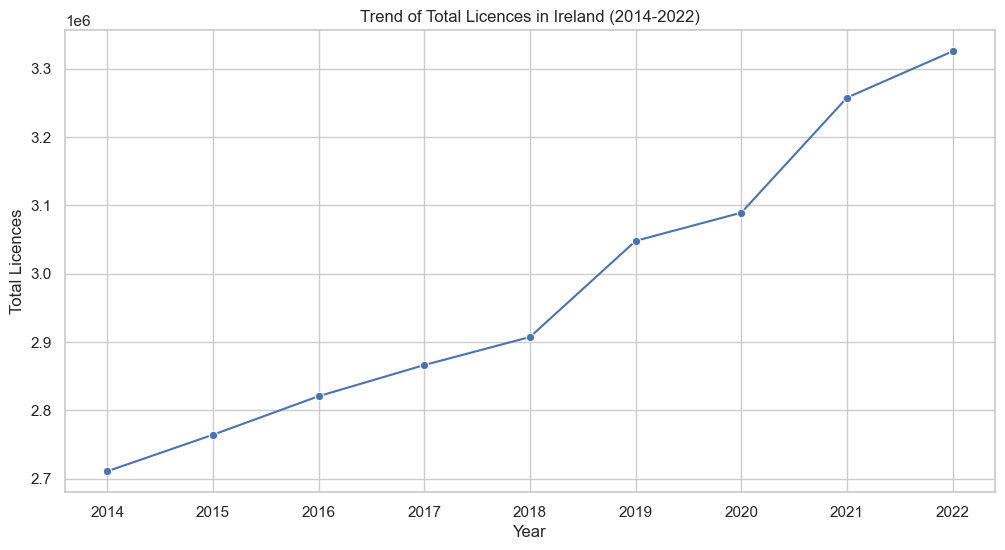

In [56]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Trend analysis for Ireland: Total Licences over the years
plt.figure(figsize=(12, 6))
sns.lineplot(data=all_ages, x="Year", y="Value", ci=None, marker='o')
plt.title("Trend of Total Licences in Ireland (2014-2022)")
plt.ylabel("Total Licences")
plt.xlabel("Year")
plt.show()

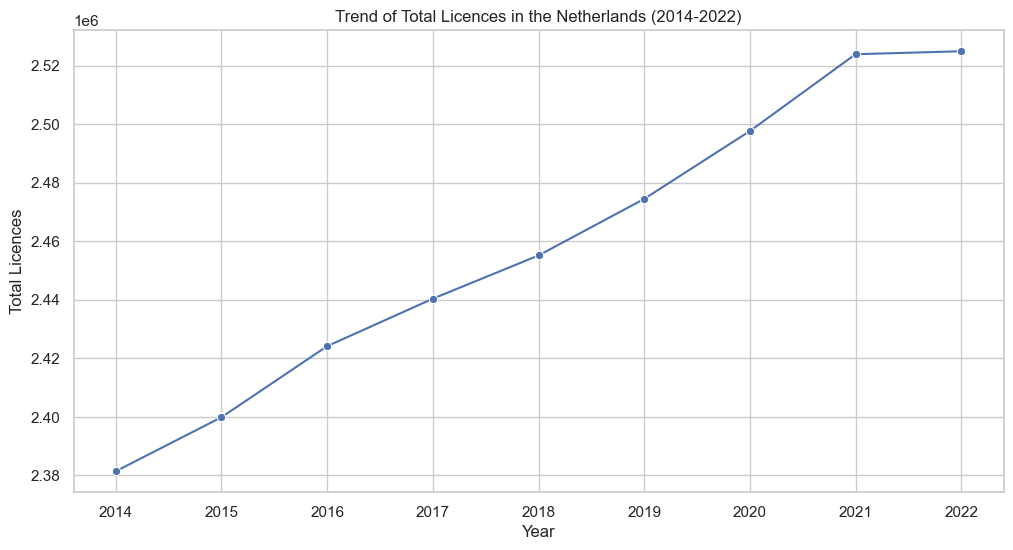

In [57]:
# Trend analysis for Netherlands: Total Licences over the years
plt.figure(figsize=(12, 6))
sns.lineplot(data=all_ages2, x="Year", y="Value", ci=None, marker='o')
plt.title("Trend of Total Licences in the Netherlands (2014-2022)")
plt.ylabel("Total Licences")
plt.xlabel("Year")
plt.show()

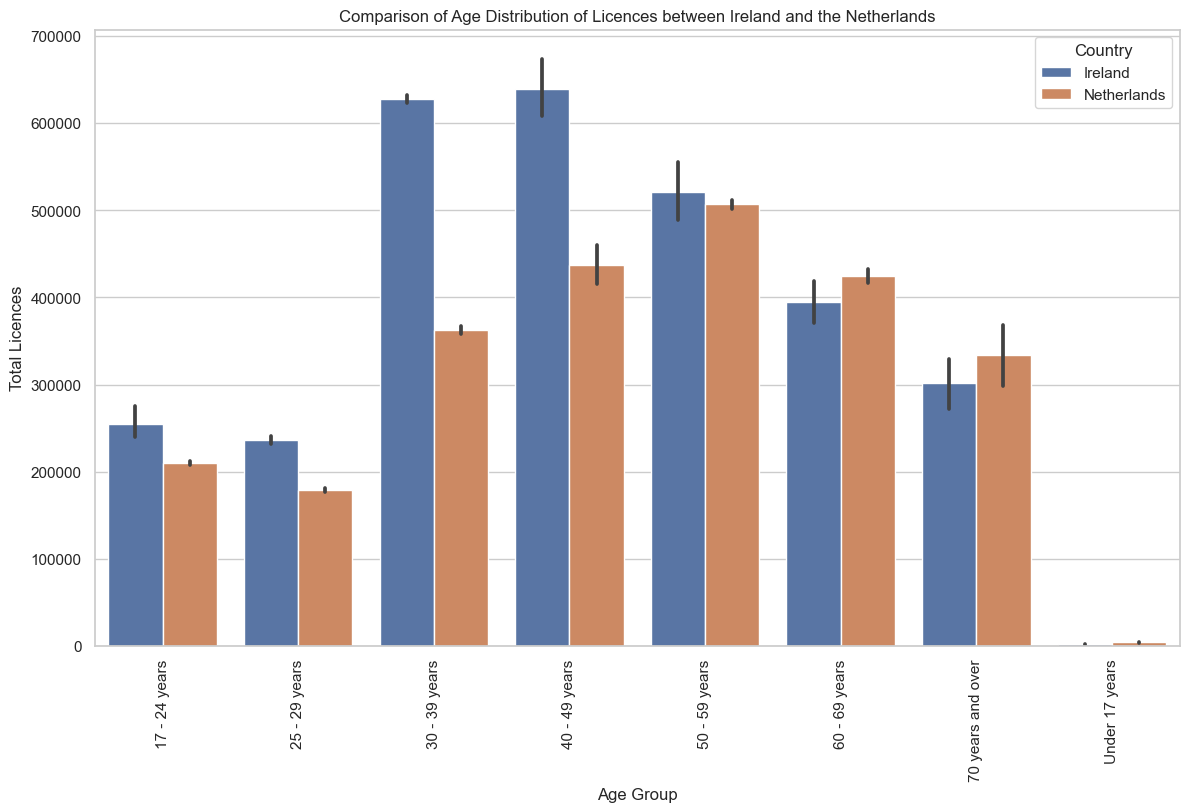

In [58]:
# Comparison of age distributions between Ireland and the Netherlands
# Concatenating the two datasets for comparison, adding a 'Country' column
df_barplot=df[df["Age Group"] != "All ages"]
df2_barplot=df2[df2["Age Group"] != "All ages"]
df_barplot['Country'] = 'Ireland'
df2_barplot['Country'] = 'Netherlands'
combined_df = pd.concat([df_barplot, df2_barplot])

# Plotting age distribution comparison
plt.figure(figsize=(14, 8))
sns.barplot(data=combined_df, x="Age Group", y="Value", hue="Country")
plt.title("Comparison of Age Distribution of Licences between Ireland and the Netherlands")
plt.ylabel("Total Licences")
plt.xlabel("Age Group")
plt.xticks(rotation=90)
plt.show()


# çıkarımsal istatistik testleri

## 1. Normal Dağılım Testi (Shapiro-Wilk Testi)

Shapiro-Wilk testi hipotest

    1- Null Hipotezi (H0): Yaş grubunun ehliyet sahiplerinin sayıları normal dağılım gösterir.
    2- Alternatif Hipotez (H1): Yaş grubunun ehliyet sahiplerinin sayıları normal dağılım göstermez.

Bu hipotezler, İrlanda ve Hollanda veri setlerindeki her bir yaş grubu için ayrı ayrı test edilecek. Shapiro-Wilk testi, p-değerine dayanarak null hipotezin reddedilip reddedilmeyeceğini belirler. Eğer p-değeri belirlenen anlamlılık eşiğinden (0.05) düşükse, bu durumda null hipotezi reddedilir ve verilerin normal dağılım göstermediği sonucuna varılır.

In [59]:
from scipy.stats import shapiro

# Shapiro-Wilk Test for normality on the 'Value' column of both datasets
shapiro_test_ireland = shapiro(df[df["Age Group"]!="All ages"]['Value'])
shapiro_test_netherlands = shapiro(df2[df2["Age Group"]!="All ages"]['Value'])
if shapiro_test_ireland.pvalue >= 0.05:
        hypothesis_ireland = "H0"
else: hypothesis_ireland = "H1"
print(hypothesis_ireland,f"Shapiro Result; Statistic: {shapiro_test_ireland.statistic:.4f}",
          f"P-value: {shapiro_test_ireland.pvalue:.6f}","Ireland")
if shapiro_test_netherlands.pvalue >= 0.05:
        hypothesis_netherlands = "H0"
else: hypothesis_netherlands = "H1"
print(hypothesis_netherlands,f"Shapiro Result; Statistic: {shapiro_test_netherlands.statistic:.4f}",
          f"P-value: {shapiro_test_netherlands.pvalue:.6f}","Netherlands")

H1 Shapiro Result; Statistic: 0.9272 P-value: 0.000454 Ireland
H1 Shapiro Result; Statistic: 0.9045 P-value: 0.000047 Netherlands


In [60]:
# Shapiro-Wilk Test for normality on the 'Value' column of both datasets
age_group = df["Age Group"].unique()
shapiro_results = {
    "Ireland": [],
    "Netherlands": []
}
for age in age_group: 
    shapiro_test_ireland = shapiro(df[df["Age Group"]==age]['Value'])
    shapiro_results["Ireland"].append((age, shapiro_test_ireland.statistic, shapiro_test_ireland.pvalue))
    shapiro_test_netherlands = shapiro(df2[df2["Age Group"]==age]['Value'])
    shapiro_results["Netherlands"].append((age, shapiro_test_netherlands.statistic, shapiro_test_netherlands.pvalue))
    if shapiro_test_ireland.pvalue  >= 0.05:
        hypothesis_ireland = "H0"
    else: hypothesis_ireland = "H1"
    print(hypothesis_ireland,f"Shapiro; Statistic: {shapiro_test_ireland.statistic:.4f}",
          f"\tP-value: {shapiro_test_ireland.pvalue:.4f}",f"\t{age}","Ireland")
    if shapiro_test_netherlands.pvalue >= 0.05:
        hypothesis_netherlands = "H0"
    else: hypothesis_netherlands = "H1"
    print(hypothesis_netherlands,f"Shapiro; Statistic: {shapiro_test_netherlands.statistic:.4f}",
          f"\tP-value: {shapiro_test_netherlands.pvalue:.4f}",f"\t{age}","Netherlands")

H1 Shapiro; Statistic: 0.7672 	P-value: 0.0086 	17 - 24 years Ireland
H0 Shapiro; Statistic: 0.9329 	P-value: 0.5096 	17 - 24 years Netherlands
H0 Shapiro; Statistic: 0.9333 	P-value: 0.5129 	25 - 29 years Ireland
H0 Shapiro; Statistic: 0.9398 	P-value: 0.5803 	25 - 29 years Netherlands
H0 Shapiro; Statistic: 0.9505 	P-value: 0.6955 	30 - 39 years Ireland
H0 Shapiro; Statistic: 0.8720 	P-value: 0.1290 	30 - 39 years Netherlands
H0 Shapiro; Statistic: 0.9452 	P-value: 0.6371 	40 - 49 years Ireland
H0 Shapiro; Statistic: 0.9588 	P-value: 0.7858 	40 - 49 years Netherlands
H0 Shapiro; Statistic: 0.9305 	P-value: 0.4861 	50 - 59 years Ireland
H0 Shapiro; Statistic: 0.8461 	P-value: 0.0675 	50 - 59 years Netherlands
H0 Shapiro; Statistic: 0.9437 	P-value: 0.6208 	60 - 69 years Ireland
H0 Shapiro; Statistic: 0.9743 	P-value: 0.9286 	60 - 69 years Netherlands
H0 Shapiro; Statistic: 0.9528 	P-value: 0.7204 	70 years and over Ireland
H0 Shapiro; Statistic: 0.9542 	P-value: 0.7358 	70 years and o

In [61]:
# Dropdown widget'ları oluşturun
age_group_dropdown_shapiro = widgets.Dropdown(
    options=list(df['Age Group'].unique()),
    description='Age Group:',
    disabled=False,
)

# Grafik çıktısını gösterecek bir çıktı alanı yaratın
output_shapiro = widgets.Output()

def update_shapiro(change):
    with output_shapiro:
        clear_output(wait=True)  # Mevcut çıktıyı temizle
        selected_age_group = age_group_dropdown_shapiro.value
        
        data_shapiro_test = df[df["Age Group"] == selected_age_group]
        data_shapiro_test2 = df2[df2["Age Group"] == selected_age_group]
        # Shapiro-Wilk Test for normality on the 'Value' column of both datasets
        shapiro_test_ireland = shapiro(data_shapiro_test['Value'])
        shapiro_test_netherlands = shapiro(data_shapiro_test2['Value'])
        
        if shapiro_test_ireland.pvalue  >= 0.05:
            hypothesis_ireland = "H0 (normal distribution)"
        else: hypothesis_ireland = "H1 (non normal distribution)"
        if shapiro_test_netherlands.pvalue >= 0.05:
            hypothesis_netherlands = "H0 (normal distribution)"
        else: hypothesis_netherlands = "H1 (non normal distribution)"
        
        print(f"Selected age group= {selected_age_group}\n")
        print(f"Ireland Hypothsis Result: {hypothesis_ireland}")
        print(f"Ireland {shapiro_test_ireland}\n")
        print(f"Netherlands Hypothsis Result: {hypothesis_netherlands}")
        print(f"Netherlands {shapiro_test_netherlands}")

# Dropdown widget'larının değişikliklerine göre grafik güncelleme
age_group_dropdown_shapiro.observe(update_shapiro, names='value')

# Widget'ları ve çıktı alanını göster
display(age_group_dropdown_shapiro, output_shapiro)
update_shapiro(None)  # İlk grafik

Dropdown(description='Age Group:', options=('17 - 24 years', '25 - 29 years', '30 - 39 years', '40 - 49 years'…

Output()

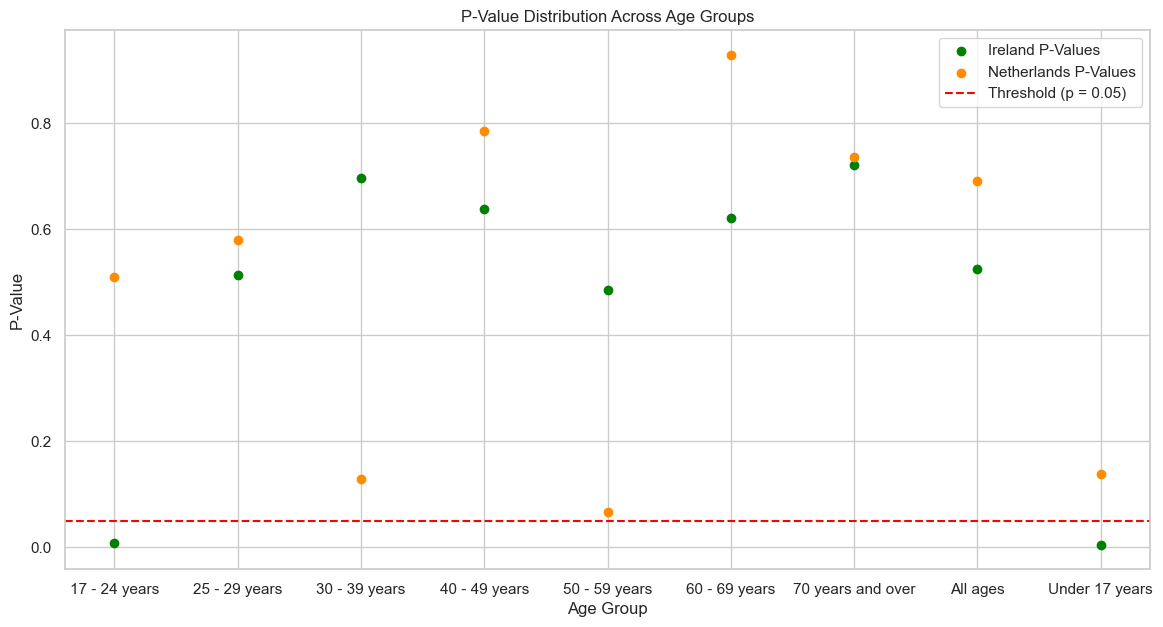

In [62]:
import pandas as pd
from scipy.stats import shapiro
import seaborn as sns
import matplotlib.pyplot as plt


# Shapiro-Wilk test sonuçlarını saklamak için boş listeler oluşturalım
shapiro_results = {
    "Ireland": [],
    "Netherlands": []
}
age_groups=df['Age Group'].unique()
# Her bir yaş grubu için Shapiro-Wilk testi yapalım
for age in age_groups:
    # Ireland verisi için
    shapiro_test_ireland = shapiro(df[df["Age Group"] == age]['Value'])
    shapiro_results["Ireland"].append((age, shapiro_test_ireland.statistic, shapiro_test_ireland.pvalue))
    
    # Netherlands verisi için
    shapiro_test_netherlands = shapiro(df2[df2["Age Group"] == age]['Value'])
    shapiro_results["Netherlands"].append((age, shapiro_test_netherlands.statistic, shapiro_test_netherlands.pvalue))

# P-Value Dağılım Grafiği
plt.figure(figsize=(14, 7))
for country, color in zip(shapiro_results, ['green', 'darkorange']):
    ages, _, p_values = zip(*shapiro_results[country])
    plt.scatter(ages, p_values, color=color, label=f'{country} P-Values')
plt.axhline(0.05, color='red', linestyle='--', label='Threshold (p = 0.05)')
plt.xlabel('Age Group')
plt.ylabel('P-Value')
plt.title('P-Value Distribution Across Age Groups')
plt.legend()
plt.show()

In [63]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Dropdown widget'ları oluşturun
country_dropdown_dist_value = widgets.Dropdown(
    options=['Ireland', 'Netherlands'],
    value='Ireland',
    description='Country:',
    disabled=False,
)

age_group_dropdown_dist_value = widgets.Dropdown(
    options=list(df['Age Group'].unique()),
    description='Age Group:',
    disabled=False,
)

# Grafik çıktısını gösterecek bir çıktı alanı yaratın
output_dist_value= widgets.Output()

# Grafik güncelleme fonksiyonu
def update_dist_value(change):
    with output_dist_value:
        clear_output(wait=True)  # Mevcut çıktıyı temizle
        selected_country = country_dropdown_dist_value.value
        selected_age_group = age_group_dropdown_dist_value.value

        if selected_country == 'Ireland':
            data = df
        else:
            data = df2

        data_dist_value = data[data['Age Group'] == selected_age_group]
        sns.histplot(data_dist_value["Value"], kde=True, bins=9)
        plt.title(f"Distribution of Licence Values for {selected_age_group} Age Group in the {selected_country}")
        plt.xticks(rotation=90)
        plt.show()
        
# Dropdown widget'larının değişikliklerine göre grafik güncelleme
country_dropdown_dist_value.observe(update_dist_value, names='value')
age_group_dropdown_dist_value.observe(update_dist_value, names='value')

# Widget'ları ve çıktı alanını göster
display(country_dropdown_dist_value, age_group_dropdown_dist_value, output_dist_value)
update_dist_value(None)  # İlk grafik

Dropdown(description='Country:', options=('Ireland', 'Netherlands'), value='Ireland')

Dropdown(description='Age Group:', options=('17 - 24 years', '25 - 29 years', '30 - 39 years', '40 - 49 years'…

Output()

In [64]:
# Additionally, plotting a Q-Q plot to visually assess the normality
import scipy.stats as stats


# Dropdown widget'ları oluşturun
country_dropdown_qq_plot = widgets.Dropdown(
    options=['Ireland', 'Netherlands'],
    value='Ireland',
    description='Country:',
    disabled=False,
)

age_group_dropdown_qq_plot = widgets.Dropdown(
    options=list(df['Age Group'].unique()),
    description='Age Group:',
    disabled=False,
)

# Grafik çıktısını gösterecek bir çıktı alanı yaratın
output_qq_plot = widgets.Output()

# Grafik güncelleme fonksiyonu
def update_qq_plot(change):
    with output_qq_plot:
        clear_output(wait=True)  # Mevcut çıktıyı temizle
        selected_country = country_dropdown_qq_plot.value
        selected_age_group = age_group_dropdown_qq_plot.value

        if selected_country == 'Ireland':
            data = df
        else:
            data = df2

        data_qq_plot = data[data['Age Group'] == selected_age_group]
        stats.probplot(data_qq_plot['Value'], dist="norm", plot=plt)
        plt.title(f"Q-Q Plot for {selected_age_group} Age Group in the {selected_country}")
        plt.show()
# Dropdown widget'larının değişikliklerine göre grafik güncelleme
country_dropdown_qq_plot.observe(update_qq_plot, names='value')
age_group_dropdown_qq_plot.observe(update_qq_plot, names='value')

# Widget'ları ve çıktı alanını göster
display(country_dropdown_qq_plot, age_group_dropdown_qq_plot, output_qq_plot)
update_qq_plot(None)  # İlk grafik

Dropdown(description='Country:', options=('Ireland', 'Netherlands'), value='Ireland')

Dropdown(description='Age Group:', options=('17 - 24 years', '25 - 29 years', '30 - 39 years', '40 - 49 years'…

Output()

## 2. T-Testi

### T-Testi Hipotezi:
    Null Hipotezi (H0): İki grubun ortalamaları arasında istatistiksel olarak anlamlı bir fark yoktur.
    Alternatif Hipotezi (H1): İki grubun ortalamaları arasında istatistiksel olarak anlamlı bir fark vardır.
    
    Null Hipotezi (H0): There is no statistically significant difference between the means of the two groups.
    Alternatif Hipotezi (H1): There is a statistically significant difference between the means of the two groups.

In [65]:
from scipy.stats import ttest_ind

# Performing Welch's T-test (which does not assume equal variances) between Ireland and Netherlands for the year 2014
ttest_result = ttest_ind(df[df["Age Group"]!="All ages"]['Value'],
                          df2[df2["Age Group"]!="All ages"]['Value'], equal_var=False)
if ttest_result.pvalue  >= 0.05:
    hypothesis_ttest = "H0 (There is no statistically significant difference between the means of the two groups.)"
else: hypothesis_ttest = "H1 (There is a statistically significant difference between the means of the two groups.)"
ttest_result
print(f"Hypothsis Result: {hypothesis_ttest}\n")
print(f"T-test Result;\nStatistic:{ttest_result.statistic:.5f}\nPvalue:\t{ttest_result.pvalue:.5f}\ndf:\t{ttest_result.df:5f}\n")

Hypothsis Result: H1 (There is a statistically significant difference between the means of the two groups.)

T-test Result;
Statistic:2.10303
Pvalue:	0.03736
df:	132.259532



In [66]:
# Dropdown widget'ları oluşturun
age_group_dropdown_ttest = widgets.Dropdown(
    options=list(df['Age Group'].unique()),
    description='Age Group:',
    disabled=False,
)

# Grafik çıktısını gösterecek bir çıktı alanı yaratın
output_ttest = widgets.Output()

def update_ttest(change):
    with output_ttest:
        clear_output(wait=True)  # Mevcut çıktıyı temizle
        selected_age_group = age_group_dropdown_ttest.value
        
        # Performing T-test between Ireland and Netherlands for the spesific age group
        ttest_result = ttest_ind(df[df["Age Group"]==selected_age_group]['Value'],
                          df2[df2["Age Group"]==selected_age_group]['Value'], equal_var=False)
        
        if ttest_result.pvalue  >= 0.05:
            hypothesis_ttest = "H0 (There is no statistically significant difference between the means of the two groups.)"
        else: hypothesis_ttest = "H1 (There is a statistically significant difference between the means of the two groups.)"
        
        print(f"Selected age group= {selected_age_group}\n")
        print(f"Hypothsis Result: {hypothesis_ttest}\n")
        print(f"T-test Result;\nStatistic:{ttest_result.statistic:.5f}\nPvalue:\t{ttest_result.pvalue:.5f}\ndf:\t{ttest_result.df:5f}\n")

# Dropdown widget'larının değişikliklerine göre grafik güncelleme
age_group_dropdown_ttest.observe(update_ttest, names='value')

# Widget'ları ve çıktı alanını göster
display(age_group_dropdown_ttest, output_ttest)
update_ttest(None)  # İlk grafik

Dropdown(description='Age Group:', options=('17 - 24 years', '25 - 29 years', '30 - 39 years', '40 - 49 years'…

Output()

In [67]:
# Re-loading the datasets due to the reset of the execution state
df_ireland = df
df_netherlands = df2

# Creating the Dropdown widget for selecting the age group
age_group_dropdown_box_plot = widgets.Dropdown(
    options=list(df['Age Group'].unique()),
    description='Age Group:',
    disabled=False,
)

output_box_plot = widgets.Output()

def update_box_plot_side_by_side(change):
    selected_age_group = age_group_dropdown_box_plot.value
    with output_box_plot:
        clear_output(wait=True)

        # Filtering the combined data for the selected age group
        # Filtering the combined data for the selected age group
        filtered_data_ireland = df_ireland[df_ireland['Age Group'] == selected_age_group]
        filtered_data_netherlands = df_netherlands[df_netherlands['Age Group'] == selected_age_group]

        # Creating subplots
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))

        # Plotting the boxplot for Ireland on the first subplot
        sns.boxplot(y='Value', data=filtered_data_ireland, ax=axes[0])
        axes[0].set_title(f'Ireland - {selected_age_group}')
        
        # Plotting the boxplot for Netherlands on the second subplot
        sns.boxplot(y='Value', data=filtered_data_netherlands, ax=axes[1])
        axes[1].set_title(f'Netherlands - {selected_age_group}')
        
        # Display the plot
        plt.tight_layout()
        plt.show()

# Reassign the observe function to the new function that plots side by side
#age_group_dropdown_box_plot.unobserve(update_box_plot, names='value')
age_group_dropdown_box_plot.observe(update_box_plot_side_by_side, names='value')

# Displaying the widgets and re-initializing the plot
display(age_group_dropdown_box_plot, output_box_plot)
update_box_plot_side_by_side(None)  # Trigger the initial plot for side by side view


Dropdown(description='Age Group:', options=('17 - 24 years', '25 - 29 years', '30 - 39 years', '40 - 49 years'…

Output()

## 3. ANOVA (Varyans Analizi) (Parametrik)

- Null Hipotezi (H0): Grupların tüm ortalamaları (popülasyon ortalamaları) arasında bir fark yoktur. Başka bir deyişle, tüm gruplar aynı popülasyonun parçasıdır ve bu nedenle ortalamaları esasında eşittir.

- Alternatif Hipotezi (H1): En az iki grup arasında ortalama farkı vardır. Bu, gruplardan en az birinin diğerlerinden farklı bir popülasyonun parçası olduğunu gösterir.

In [68]:
from scipy.stats import f_oneway
# Prepare the data for ANOVA
anova_results = {}
df_f_oneway=df[df["Age Group"] != "All ages"]["Value"]
df2_f_oneway=df2[df2["Age Group"] != "All ages"]["Value"]
f_stat, p_value = f_oneway(df_f_oneway, df2_f_oneway)
anova_results = {'F-Statistic': f_stat, 'p-value': p_value}
print(f"F-Statistic: {f_stat:.4f}",f"\tP-Value: {p_value:.4f}")

F-Statistic: 4.4228 	P-Value: 0.0372


In [69]:
# Prepare the data for ANOVA
anova_results = {}
#age_groups = df["Age Group"].unique()

for age_group in age_groups:
    # Get the values for Ireland and Netherlands for this age group
    ireland_values = df[df["Age Group"] == age_group]["Value"]
    netherlands_values = df2[df2["Age Group"] == age_group]["Value"]
    
    # Perform ANOVA (Analysis of Variance) test
    f_stat, p_value = f_oneway(ireland_values, netherlands_values)
    anova_results[age_group] = {'F-Statistic': f_stat, 'p-value': p_value}
    print(f"F-Statistic {f_stat:.4f}",f"\tP-Value {p_value:.4f}",f"\t\t{age_group}")


F-Statistic 22.0162 	P-Value 0.0002 		17 - 24 years
F-Statistic 428.5690 	P-Value 0.0000 		25 - 29 years
F-Statistic 5084.0063 	P-Value 0.0000 		30 - 39 years
F-Statistic 86.0949 	P-Value 0.0000 		40 - 49 years
F-Statistic 0.6134 	P-Value 0.4449 		50 - 59 years
F-Statistic 4.4470 	P-Value 0.0511 		60 - 69 years
F-Statistic 1.7742 	P-Value 0.2015 		70 years and over
F-Statistic 48.7577 	P-Value 0.0000 		All ages
F-Statistic 48.6462 	P-Value 0.0000 		Under 17 years


## 4. Mann-Whitney U Testi

In [70]:
from scipy.stats import mannwhitneyu

# Selecting the data for the year 2014 from both datasets
ireland_2014 = df[df["Year"] == 2014]["Value"]
netherlands_2014 = df2[df2["Year"] == 2014]["Value"]

# Performing Mann-Whitney U Test between Ireland and Netherlands for the year 2014
mannwhitney_test_2014 = mannwhitneyu(ireland_2014, netherlands_2014)

mannwhitney_test_2014


MannwhitneyuResult(statistic=44.0, pvalue=0.7910815129207817)

In [71]:
from scipy.stats import mannwhitneyu
years=df["Year"].unique()
# Performing Mann-Whitney U Test between Ireland and Netherlands for the years
for year in years:
    ireland_years = df[df["Year"] == year]["Value"]
    netherlands_years = df2[df2["Year"] == year]["Value"]
    mannwhitney_test_years = mannwhitneyu(ireland_years, netherlands_years)
    print(year,"=",mannwhitney_test_years)

2014 = MannwhitneyuResult(statistic=44.0, pvalue=0.7910815129207817)
2015 = MannwhitneyuResult(statistic=44.0, pvalue=0.7910815129207817)
2016 = MannwhitneyuResult(statistic=46.0, pvalue=0.6588432549492806)
2017 = MannwhitneyuResult(statistic=46.0, pvalue=0.6588432549492806)
2018 = MannwhitneyuResult(statistic=46.0, pvalue=0.6588432549492806)
2019 = MannwhitneyuResult(statistic=47.0, pvalue=0.5962416305866567)
2020 = MannwhitneyuResult(statistic=48.0, pvalue=0.5364994693194564)
2021 = MannwhitneyuResult(statistic=49.0, pvalue=0.47992869214595724)
2022 = MannwhitneyuResult(statistic=50.0, pvalue=0.42677673653298365)


In [72]:
from scipy.stats import mannwhitneyu
years=df["Year"].unique()
# Performing Mann-Whitney U Test between Ireland and Netherlands for the years 
df_no_all_ages = df[df["Age Group"] != "All ages"]
df2_no_all_ages = df2[df2["Age Group"] != "All ages"]

for year in years:
    ireland_years = df_no_all_ages[df_no_all_ages["Year"] == year]["Value"]
    netherlands_years = df2_no_all_ages[df2_no_all_ages["Year"] == year]["Value"]
    mannwhitney_test_years = mannwhitneyu(ireland_years, netherlands_years)
    print(year,"=",mannwhitney_test_years)

2014 = MannwhitneyuResult(statistic=35.0, pvalue=0.7984459984459983)
2015 = MannwhitneyuResult(statistic=35.0, pvalue=0.7984459984459983)
2016 = MannwhitneyuResult(statistic=37.0, pvalue=0.6453768453768453)
2017 = MannwhitneyuResult(statistic=37.0, pvalue=0.6453768453768453)
2018 = MannwhitneyuResult(statistic=37.0, pvalue=0.6453768453768453)
2019 = MannwhitneyuResult(statistic=38.0, pvalue=0.5737373737373737)
2020 = MannwhitneyuResult(statistic=39.0, pvalue=0.5053613053613053)
2021 = MannwhitneyuResult(statistic=40.0, pvalue=0.4418026418026417)
2022 = MannwhitneyuResult(statistic=41.0, pvalue=0.3822843822843822)


In [73]:
# Performing Mann-Whitney U Test on the entire datasets for 'Value' column
mannwhitney_test_result = mannwhitneyu(df['Value'], df2['Value'])
print("Results with whole data set")
print(f"mannwhitney Statistic Result= {mannwhitney_test_result.statistic}")
print(f"mannwhitney p-value Result= {round(mannwhitney_test_result.pvalue,4)}")

Results with whole data set
mannwhitney Statistic Result= 3813.0
mannwhitney p-value Result= 0.0747


In [74]:
# Performing Mann-Whitney U Test on the entire datasets for 'Value' column

df_no_all_ages = df[df["Age Group"] != "All ages"]
df2_no_all_ages = df2[df2["Age Group"] != "All ages"]

mannwhitney_test_result_no_all_ages = mannwhitneyu(df_no_all_ages["Value"], df2_no_all_ages["Value"])
print("Results with 'All ages' age group removed from the data set")
print(f"mannwhitney Statistic Result= {mannwhitney_test_result_no_all_ages.statistic}")
print(f"mannwhitney p-value Result= {round(mannwhitney_test_result_no_all_ages.pvalue,4)}")

Results with 'All ages' age group removed from the data set
mannwhitney Statistic Result= 3084.0
mannwhitney p-value Result= 0.0496


In [75]:
# Dropdown widget'ları oluşturun
age_group_dropdown_mannwhitney = widgets.Dropdown(
    options=list(df['Age Group'].unique()),
    description='Age Group:',
    disabled=False,
)

# Grafik çıktısını gösterecek bir çıktı alanı yaratın
output_mannwhitney = widgets.Output()

# Grafik güncelleme fonksiyonu
def update_mannwhitney(change):
    with output_mannwhitney:
        clear_output(wait=True)  # Mevcut çıktıyı temizle
        selected_age_group = age_group_dropdown_mannwhitney.value

        data_mannwhitney = df[df["Age Group"] == selected_age_group]
        data_mannwhitney2 = df2[df2["Age Group"] == selected_age_group]
        mannwhitney_test_result= mannwhitneyu(data_mannwhitney['Value'], data_mannwhitney2['Value'])
        print(f"Selected age group= {selected_age_group}\n")
        print(f"mannwhitney Statistic Result= {mannwhitney_test_result.statistic}")
        print(f"mannwhitney p-value Result= {round(mannwhitney_test_result.pvalue,5)}")
# Dropdown widget'larının değişikliklerine göre grafik güncelleme
age_group_dropdown_mannwhitney.observe(update_mannwhitney, names='value')

# Widget'ları ve çıktı alanını göster
display(age_group_dropdown_mannwhitney, output_mannwhitney)
update_mannwhitney(None)  # İlk grafik

Dropdown(description='Age Group:', options=('17 - 24 years', '25 - 29 years', '30 - 39 years', '40 - 49 years'…

Output()

## 5. Kruskal-Wallis H Testi

In [76]:
from scipy.stats import kruskal

# Extracting values for different age groups in Ireland for the year 2014
age_groups = df['Age Group'].unique()
values_by_age_group = [df[(df['Year'] == 2014) & (df['Age Group'] == age)].Value for age in age_groups]

# Performing Kruskal-Wallis H Test among different age groups in Ireland for the year 2014
kruskal_test = kruskal(*values_by_age_group)

kruskal_test

KruskalResult(statistic=8.0, pvalue=0.43347012036670896)

In [77]:
# Preparing the data for Kruskal-Wallis H Test
# We'll consider each age group in each country as a separate group for the test

# Extracting the age groups
age_groups = df['Age Group'].unique()

# Preparing an empty list to store the values of each group
values_by_age_group = []

# Extracting values for each age group from both datasets
for age_group in age_groups:
    if age_group != 'All ages':  # Excluding the 'All ages' group
        ireland_values = df[df['Age Group'] == age_group]['Value']
        netherlands_values = df2[df2['Age Group'] == age_group]['Value']
        
        # Appending the values to the list
        values_by_age_group.extend([ireland_values, netherlands_values])
# Performing Kruskal-Wallis H Test across all age groups and countries
kruskal_test_result = kruskal(*values_by_age_group)

kruskal_test_result


KruskalResult(statistic=138.63665389527466, pvalue=4.274481956243129e-22)

In [78]:
from scipy.stats import kruskal

# Filtering out 'All ages' group from both datasets
df_filtered = df[df['Age Group'] != 'All ages']
df2_filtered = df2[df2['Age Group'] != 'All ages']

# Preparing the data for Kruskal-Wallis H Test
# Extracting the age groups
age_groups = df_filtered['Age Group'].unique()

# Re-performing Kruskal-Wallis H Test across all age groups for both countries
kruskal_test_results = {}

for age_group in age_groups:
    ireland_values = df_filtered[df_filtered['Age Group'] == age_group]['Value']
    netherlands_values = df2_filtered[df2_filtered['Age Group'] == age_group]['Value']

    # Perform Kruskal-Wallis H test for this age group
    H_stat, p_value = kruskal(ireland_values, netherlands_values)
    kruskal_test_results[age_group] = {'H_stat': round(H_stat,4), 'p_value': round(p_value,4)}

kruskal_test_results


{'17 - 24 years': {'H_stat': 12.7895, 'p_value': 0.0003},
 '25 - 29 years': {'H_stat': 12.7895, 'p_value': 0.0003},
 '30 - 39 years': {'H_stat': 12.7895, 'p_value': 0.0003},
 '40 - 49 years': {'H_stat': 12.7895, 'p_value': 0.0003},
 '50 - 59 years': {'H_stat': 0.0019, 'p_value': 0.9648},
 '60 - 69 years': {'H_stat': 2.1228, 'p_value': 0.1451},
 '70 years and over': {'H_stat': 1.6394, 'p_value': 0.2004},
 'Under 17 years': {'H_stat': 11.5575, 'p_value': 0.0007}}

## 6. Spearman'ın Sıra Korelasyonu

In [79]:
from scipy.stats import spearmanr

# Calculating the total number of licences per year in Ireland
total_licences_per_year_ireland = df.groupby('Year')['Value'].sum()

# Performing Spearman's rank correlation between years and total licences in Ireland
spearman_correlation = spearmanr(total_licences_per_year_ireland.index, total_licences_per_year_ireland)

spearman_correlation


SignificanceResult(statistic=1.0, pvalue=0.0)

# Machine Learning

In [80]:
# Basic statistical summary of the dataset
statistical_summary = df.describe()

# Checking for missing values
missing_values = df.isnull().sum()

# Understanding the distribution of age groups and years
age_group_distribution = df["Age Group"].value_counts()
year_distribution = df["Year"].value_counts()

statistical_summary, missing_values, age_group_distribution, year_distribution


(              Year         Value
 count    81.000000  8.100000e+01
 mean   2018.000000  6.614900e+05
 std       2.598076  8.494945e+05
 min    2014.000000  1.243000e+03
 25%    2016.000000  2.396400e+05
 50%    2018.000000  3.884350e+05
 75%    2020.000000  6.230160e+05
 max    2022.000000  3.325487e+06,
 Year         0
 Age Group    0
 Value        0
 dtype: int64,
 Age Group
 17 - 24 years        9
 25 - 29 years        9
 30 - 39 years        9
 40 - 49 years        9
 50 - 59 years        9
 60 - 69 years        9
 70 years and over    9
 All ages             9
 Under 17 years       9
 Name: count, dtype: int64,
 Year
 2014    9
 2015    9
 2016    9
 2017    9
 2018    9
 2019    9
 2020    9
 2021    9
 2022    9
 Name: count, dtype: int64)

RMSE, modelin tahminlerinin gerçek değerlerden ne kadar sapma gösterdiğinin bir ölçüsüdür. Genellikle, daha düşük bir RMSE değeri, modelin daha iyi performans gösterdiğini gösterir. Bu durumda RMSE oldukça yüksek çıkmıştır, bu da modelin hedef değişkeni oldukça geniş bir hata marjı ile tahmin ettiğini göstermektedir.

R-kare (R²) ise, bağımsız değişkenlerin bağımlı değişkendeki varyansı ne kadar açıkladığının bir göstergesidir. 0 ile 1 arasında değerler alır ve genellikle daha yüksek bir R² değeri, modelin verileri daha iyi açıkladığını gösterir. Bu durumda R² değeri oldukça düşüktür, bu da modelin verinin varyansını yeterince açıklayamadığını göstermektedir.

## Random Forest Regressor

In [81]:
# Re-importing necessary libraries due to execution state reset
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Step 1: Data Preparation
# Load the dataset
df_RFR = df.copy()

# Encode the 'Age Group' categorical data to numeric
label_encoder = LabelEncoder()
df_RFR['Age Group Encoded'] = label_encoder.fit_transform(df_RFR['Age Group'])

# Selecting features and target variable
X = df_RFR[['Year', 'Age Group Encoded']]  # Features
y = df_RFR['Value']  # Target variable

# Step 2: Splitting the Data into Training and Testing Sets
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"{df.head}\n")
print("X_train:\n",f"{X_train.head()}\n")
print("y_train:\n",f"{y_train.head()}\n")

<bound method NDFrame.head of     Year          Age Group    Value
0   2014      17 - 24 years   237524
1   2014      25 - 29 years   245595
2   2014      30 - 39 years   629313
3   2014      40 - 49 years   568308
4   2014      50 - 59 years   454946
..   ...                ...      ...
76  2022      50 - 59 years   601477
77  2022      60 - 69 years   452487
78  2022  70 years and over   367798
79  2022           All ages  3325487
80  2022     Under 17 years     2243

[81 rows x 3 columns]>

X_train:
     Year  Age Group Encoded
61  2020                  7
55  2020                  1
40  2018                  4
9   2015                  0
64  2021                  1

y_train:
 61    3089212
55     227585
40     508060
9      238607
64     238710
Name: Value, dtype: int32



2. Ön İşleme ve Özellik Mühendisliği:
'Age Group' sütunu LabelEncoder kullanılarak sayısal değerlere dönüştürüldü ve 'Year' ile 'Age Group Encoded' özellikler olarak seçildi.

Eğitim setinin ilk beş satırı şöyle:

In [82]:
# Step 3: Define the Random Forest Regressor and Parameter Grid
# Define the Random Forest Regressor
rf = RandomForestRegressor(random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [50,70,100,200],  # Number of trees in the forest
    'max_depth': [None,20,30,40],     # Maximum depth of the trees
    'min_samples_split': [2,4,5,6]  # Minimum number of samples required to split an internal node
}

print(f"{param_grid}\n")

{'n_estimators': [50, 70, 100, 200], 'max_depth': [None, 20, 30, 40], 'min_samples_split': [2, 4, 5, 6]}



In [83]:
# Step 5: Create and Fit GridSearchCV
# Create GridSearchCV object with the Random Forest Regressor and the defined parameter grid
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the GridSearchCV object to the training data to find the best parameters
grid_search_rf.fit(X_train, y_train)
# Extract the best parameters from GridSearchCV
best_params_rf = grid_search_rf.best_params_
best_params_rf

{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}

In [84]:
# Step 6: Train the Random Forest Model with the Best Parameters
# Extract the best parameters from GridSearchCV
best_params_rf = grid_search_rf.best_params_

# Create a new Random Forest Regressor with the best parameters
best_rf_model = RandomForestRegressor(
    n_estimators=best_params_rf['n_estimators'],
    max_depth=best_params_rf['max_depth'],
    min_samples_split=best_params_rf['min_samples_split'],
    random_state=42
)

# Fit the model with the best parameters to the training data
best_rf_model.fit(X_train, y_train)

# Predict the values for the test set
y_pred_rf = best_rf_model.predict(X_test)

# Calculate the performance metrics for the Random Forest model
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
r2_rf = r2_score(y_test, y_pred_rf)

rmse_rf, r2_rf


(33727.58129332596, 0.9976727405573973)

In [85]:
# Creating a DataFrame for the predicted values
predicted_df_RFR = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_rf})
predicted_df_RFR.reset_index(drop=True, inplace=True)
predicted_df_RFR.head()

,Actual,Predicted
0,613128,617778.635
1,237524,241425.880
2,479959,490892.700
3,491487,507929.475
4,239640,237263.480


In [86]:
import matplotlib.pyplot as plt
import numpy as np

# Creating a Dropdown widget for selecting the year
year_dropdown_RFR = widgets.Dropdown(
    options=df['Year'].unique(),
    #value=2022,  # Default value
    description='Year:',
    disabled=False,
)

# Grafik çıktısını gösterecek bir çıktı alanı yaratın
output_RFR = widgets.Output()

# Grafik güncelleme fonksiyonu
def update_RFR(change):
    with output_RFR:
        clear_output(wait=True)  # Mevcut çıktıyı temizle
        selected_year_RFR = year_dropdown_RFR.value
        # Since we need to predict for the year 2022, we'll create a new feature set for that year
        # We assume that 'Age Group Encoded' ranges from 0 to the max value seen in the training set
        age_groups_encoded = np.arange(df_RFR['Age Group Encoded'].max() + 1)
        year_predict = np.full(shape=age_groups_encoded.shape, fill_value= selected_year_RFR)
        
        # Create a new DataFrame for the selected year predictions
        predict_df = pd.DataFrame({
            'Year': year_predict,
            'Age Group Encoded': age_groups_encoded
        })

        # Use the best Random Forest model to predict the 'Value' for each age group in 2022
        predicted_values = best_rf_model.predict(predict_df)

        # Here, we'll use the last known value for each age group as a placeholder for the true value.
        true_values = df[df['Year'] == selected_year_RFR]['Value'].values

        # Add the predictions to the DataFrame
        predict_df['Predicted Value'] = predicted_values.astype(int)

        # Compute error (absolute difference) between the true and predicted values

        predict_df['True Value'] = true_values
        predict_df['Error'] = (abs(predict_df['Predicted Value'] - predict_df['True Value'])).astype(int)
        #predict_df['Error'] = predict_df['Error'].astype(int)
        predict_df['Error Percentage'] = ((predict_df['Error'] / predict_df['True Value']) * 100).round(2)
        predict_df['Age Group'] = label_encoder.inverse_transform(predict_df['Age Group Encoded'])
        # Display the table
        prediction_table = predict_df[['Year', 'Age Group', 'True Value', 'Predicted Value', 'Error','Error Percentage']]

        # Returning the prediction table
        display(prediction_table)

# Dropdown widget'larının değişikliklerine göre grafik güncelleme
year_dropdown_RFR.observe(update_RFR, names='value')

# Widget'ları ve çıktı alanını göster
display(year_dropdown_RFR, output_RFR)
update_RFR(None)  # İlk grafik

Dropdown(description='Year:', options=(2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022), value=2014)

Output()

In [87]:
import matplotlib.pyplot as plt
import numpy as np

# We assume that 'Age Group Encoded' ranges from 0 to the max value seen in the training set
age_groups_encoded = np.arange(df_RFR['Age Group Encoded'].max() + 1)
year_2022 = np.full(shape=age_groups_encoded.shape, fill_value=2022)

# Create a new DataFrame for the year 2022 predictions
predict_df = pd.DataFrame({
    'Year': year_2022,
    'Age Group Encoded': age_groups_encoded
})

# Use the best Random Forest model to predict the 'Value' for each age group in 2022
predicted_values_2022 = best_rf_model.predict(predict_df)

# Here, we'll use the last known value for each age group as a placeholder for the true value.
# Compute error (absolute difference) between the true and predicted values
# Add the predictions to the DataFrame
predict_df['Predicted Value'] = predicted_values_2022.astype(int)
true_values_2022 = df[df['Year'] == 2022]['Value'].values
predict_df['True Value'] = true_values_2022
predict_df['Error'] = abs(predict_df['Predicted Value'] - predict_df['True Value']).astype(int)

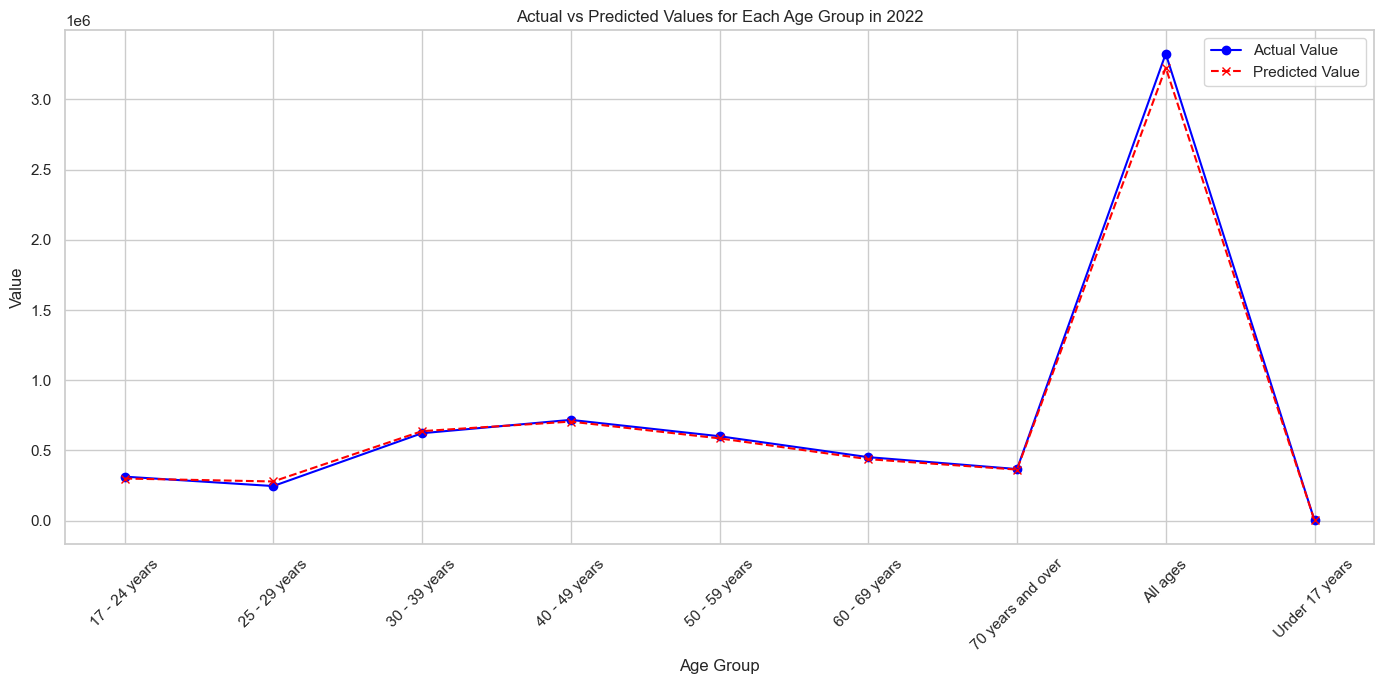

In [88]:
# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(age_groups_encoded, true_values_2022, label="Actual Value", color="blue", marker="o")
plt.plot(age_groups_encoded, predicted_values_2022, label="Predicted Value", color="red", linestyle="--", marker="x")
plt.title("Actual vs Predicted Values for Each Age Group in 2022")
plt.xlabel("Age Group")
plt.ylabel("Value")
plt.xticks(ticks=age_groups_encoded, labels=label_encoder.inverse_transform(age_groups_encoded), rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()


In [89]:
import matplotlib.pyplot as plt
import numpy as np


# "Under 17 years" yaş grubu için yıllara göre daha önce yapılan tahminleri ve gerçek değerleri içeren bir bar plot çizdirelim.
# Creating a Dropdown widget for selecting the year
dropdown_RFR_age = widgets.Dropdown(
    options=df_RFR['Age Group'].unique(),
    description='Year:',
    disabled=False,
)

# Grafik çıktısını gösterecek bir çıktı alanı yaratın
output_RFR_age = widgets.Output()
def update_RFR_age(change):
    with output_RFR_age:
        clear_output(wait=True)  # Mevcut çıktıyı temizle
        selected_RFR_age = dropdown_RFR_age.value
        
        # "Under 17 years" yaş grubunu seçelim.
        under_17_age_group_encoded = label_encoder.transform([selected_RFR_age])[0]
        years_RFR_age = df_RFR["Year"].unique()

        # 'all_predictions' DataFrame'ini tekrar oluşturalım.
        # Yıllar ve yaş grupları için tahminleri tekrar oluşturuyoruz.
        all_predictions_df_RFR_age = []
        for year in years_RFR_age:
            year_array = np.full(shape=(1,), fill_value=year)
            age_group_encoded = label_encoder.transform([selected_RFR_age])
            predict_df_RFR_age = pd.DataFrame({
                'Year': year_array,
                'Age Group Encoded': age_group_encoded
            })
            predicted_value_RFR_age = best_rf_model.predict(predict_df_RFR_age)
            true_value = df_RFR[(df_RFR['Year'] == year) & 
                                      (df_RFR['Age Group Encoded'] == under_17_age_group_encoded)]['Value'].values
            # Eğer o yıl için gerçek değer yoksa, tahmin değerini kullan
            true_value = true_value[0] if true_value.size > 0 else predicted_value_RFR_age[0]
            all_predictions_df_RFR_age.append((year, true_value, predicted_value_RFR_age[0]))

        # Tahminlerden oluşan bir DataFrame yaratın.
        predictions_df_RFR_age = pd.DataFrame(all_predictions_df_RFR_age, columns=['Year', 'Actual Value', 'Predicted Value RFR'])

        # Bar plot çizdirelim.
        plt.figure(figsize=(14, 7))
        width = 0.35  # Bar genişliğini tanımlayalım
        plt.bar(predictions_df_RFR_age['Year'] - width/2, predictions_df_RFR_age['Actual Value'], width, label='Actual Values', color='blue')
        plt.bar(predictions_df_RFR_age['Year'] + width/2, predictions_df_RFR_age['Predicted Value RFR'], width, label='Predicted Values RFR', color='red')

        plt.title(f'Actual vs Predicted Population Values for {selected_RFR_age} Over the Years')
        plt.xlabel('Year')
        plt.ylabel('Population Value RFR')
        plt.xticks(predictions_df_RFR_age['Year'], rotation=45)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Dropdown widget'larının değişikliklerine göre grafik güncelleme
dropdown_RFR_age.observe(update_RFR_age, names='value')

# Widget'ları ve çıktı alanını göster
display(dropdown_RFR_age, output_RFR_age)
update_RFR_age(None)  # İlk grafik

Dropdown(description='Year:', options=('17 - 24 years', '25 - 29 years', '30 - 39 years', '40 - 49 years', '50…

Output()

The graph comparing actual and predicted values for each age group in 2022 shows that the model's predictions closely align with the actual data for most age groups. This suggests that the model has learned the distribution well and is able to generalize from the training data to make accurate predictions. However, there is a significant deviation in the prediction for the 'All ages' category. This deviation indicates a potential area for improvement, which could involve examining the features that contribute to this prediction and considering any data anomalies or external factors that might affect the model's performance.

For a detailed analysis, it would be important to consider factors such as changes in population demographics, policy changes affecting licensing, and economic factors that could influence the number of license holders. These factors could provide insights into why certain predictions may not align with actual values and could inform further model refinement.

Overall, the Random Forest model appears to have performed well, with high accuracy for most age groups. To build on this analysis, further steps could include performing cross-validation to assess the model's stability, checking feature importance to understand the drivers of the model's predictions, and exploring model explainability tools to gain deeper insights into how the model is making its decisions. These additional analyses would provide a more comprehensive understanding of the model's performance and areas for improvement.

## Gradient Boosting Regresyon 

In [90]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Kategorik veriyi dönüştürme
label_encoder = LabelEncoder()
df_GBR=df.copy()
df_GBR['Age Group Encoded'] = label_encoder.fit_transform(df_GBR['Age Group'])

# Özellikler ve hedef değişkeni ayırma
X = df_GBR[['Year', 'Age Group Encoded']]
y = df_GBR['Value']

# Veriyi eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Eğitim ve test setlerinin boyutlarını kontrol etme
X_train_shape, X_test_shape = X_train.shape, X_test.shape

X_train_shape, X_test_shape


((64, 2), (17, 2))

ilk adim olarak veri hariligini gerçekleştirdim.

Veri setinden model için uygun özelliklerin seçilmesi icin özellik mühendisliği uyguladim."Year" ve "Age Group" sütunlarını özellik olarak kullandim, ancak "Age Group" sütunu kategorik veri içeriyor. Bu nedenle, bu sütunu sayısal bir formata dönüştürdum.

- "Age Group" sütunu, Label Encoder kullanılarak sayısal bir formata dönüştürdum.
- Özellikler (X) olarak "Year" ve dönüştürülmüş "Age Group Encoded" sütunlarıni seçitim. Hedef değişken (y) olarak "Value" sütununu kullandim.
- Veri seti, %80 eğitim ve %20 test olacak şekilde ikiye ayirdim.

In [91]:
from sklearn.ensemble import GradientBoostingRegressor

# Gradient Boosting Regresör modelini başlatma
# Başlangıç olarak varsayılan parametreler kullanılıyor
gbr_model = GradientBoostingRegressor(random_state=42)

# Model parametrelerini görüntüleme
model_parameters = gbr_model.get_params()

model_parameters


{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 42,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

Gradient Boosting modelini oluştururken belirlememiz gereken bazı önemli parametreler şunlardır:

- n_estimators: Modelde kullanılacak zayıf öğrenme modellerinin (genellikle karar ağaçları) sayısı. Çok fazla estimator, modelin eğitim verilerine aşırı uyum sağlamasına ve genelleme yapamamasına sebep olabilir.
- learning_rate: Her bir zayıf öğrenme modelinin katkısının ölçeği. Düşük bir öğrenme oranı, daha fazla estimator gerektirebilir ama genellikle daha iyi genelleme performansı sağlar.
- max_depth: Her bir karar ağacının maksimum derinliği. Derinlik arttıkça model daha karmaşık hale gelir, ancak aşırı derinlik aşırı uyuma yol açabilir.

Başlangıç olarak, bu parametreleri varsayılan değerlerle ayarlayacağım. Daha sonra, modelin performansını iyileştirmek için bu parametreleri ayarlamamız gerekebilir. Şimdi modeli oluşturalım ve başlangıç parametrelerini belirleyelim.

Bu adımda, modelin başlangıç parametrelerini belirledim.

- learning_rate: 0.1
- n_estimators: 100 (Modelde kullanılacak zayıf öğrenme modellerinin sayısı)
- max_depth: 3 (Her bir karar ağacının maksimum derinliği)
- loss: 'squared_error' (Kayıp fonksiyonu)
- alpha: 0.9 (Güven aralığı için alpha değeri)
- Diğer Parametreler: Varsayılan değerler ile ayarlandı.

In [92]:
# Gradient Boosting Regresör modelini eğitme
gbr_model.fit(X_train, y_train)

# Eğitim veri seti üzerinde modelin performansını değerlendirme
train_score = gbr_model.score(X_train, y_train)

train_score


0.999961403971959

Bu adımda, daha önce ayırdığımız eğitim veri seti üzerinde modeli eğittim.

Gradient Boosting Regresör modeli eğitim veri seti üzerinden eğittim. Modelin eğitim seti üzerindeki performansını ölçen R² skoru yaklaşık olarak 0.9999 cikti. Bu, modelin eğitim verilerine neredeyse mükemmel bir şekilde uyum sağladığını gösterir.

Ancak, bu kadar yüksek bir skor, modelin eğitim verilerine aşırı uyum sağlamış olabileceğini (overfitting) de gösterebilir. Modelin gerçek performansını anlamak için test veri seti üzerinde de değerlendirme yapılması önemlidir. Ayrıca, modelin genelleştirme yeteneğini daha iyi anlamak için çapraz doğrulama (cross-validation) gibi teknikler de kullanılabilir.

In [93]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Test veri seti üzerinde tahminler yapma
y_pred = gbr_model.predict(X_test)

# Test seti üzerinde modelin performansını değerlendirme
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mse, mae, r2


(1812648178.1365707, 17304.263859495684, 0.9962915884547928)

- Ortalama Kare Hata (MSE - Mean Squared Error): 1,812,648,178.14
- Ortalama Mutlak Hata (MAE - Mean Absolute Error): 17,304.26
- R² Skoru: 0.9963

Bu sonuçlar, modelin test veri seti üzerinde de oldukça iyi performans gösterdiğini gösteriyor. R² skoru, modelin test setindeki varyansın %99.63'ünü açıklayabildiğini belirtiyor. Ancak, MSE ve MAE değerleri, modelin bazı tahminlerde önemli hatalar yapmış olabileceğine işaret ediyor.

Genel olarak, modelin hem eğitim hem de test setlerinde yüksek performans gösterdiğini söyleyebiliriz. Ancak, modelin eğitim setine aşırı uyum sağlamış olabileceği (overfitting) ihtimalini göz önünde bulundurmak önemlidir. Bu durumu daha iyi anlamak için, modelin hiperparametrelerinin ayarlanması ve çapraz doğrulama gibi tekniklerin kullanılması faydalı olabilir. ​

In [94]:
from sklearn.model_selection import GridSearchCV

# Hiperparametre aralıklarını tanımlama
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

# Grid Search ile hiperparametre ayarlama
grid_search = GridSearchCV(estimator=gbr_model, param_grid=param_grid, cv=3, n_jobs=-1, scoring='r2')
grid_search.fit(X_train, y_train)

# En iyi parametreleri ve skoru bulma
best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_params, best_score


({'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 150},
 0.9960777193105312)

Bu adımda n_estimators, learning_rate, max_depth gibi parametreleri baktik. En iyi sonuçları veren parametre kombinasyonunu belirledikten sonra, modeli bu parametrelerle yeniden eğittim.

Grid Search yöntemiyle yapılan hiperparametre ayarlamasının sonuçları şu şekildedir: En İyi Parametreler:
- learning_rate: 0.2
- max_depth: 3
- n_estimators: 150

Bu parametrelerle elde edilen en iyi R² skoru: 0.9961


Bu sonuçlar, belirtilen hiperparametre kombinasyonunun eğitim veri setinde modelin performansını en üst düzeye çıkardığını gösteriyor. Bu parametrelerle model, eğitim setindeki varyansın yaklaşık %99.61'ini açıklayabiliyor.

In [95]:
# En iyi parametrelerle Gradient Boosting Regresör modelini tekrar oluşturma
best_gbr_model = GradientBoostingRegressor(
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    random_state=42
)

# Modeli eğitim veri seti üzerinde tekrar eğitme
best_gbr_model.fit(X_train, y_train)

# Test veri seti üzerinde tahminler yapma ve modelin performansını değerlendirme
y_pred_best = best_gbr_model.predict(X_test)
mse_best = mean_squared_error(y_test, y_pred_best)
mae_best = mean_absolute_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

mse_best, mae_best, r2_best


(1806179945.9446373, 17872.848557582427, 0.996304821506428)

En iyi parametrelerle yeniden eğitilen Gradient Boosting Regresör modelinin test veri seti üzerindeki performans değerlendirmesi şu şekildedir:

- Ortalama Kare Hata (MSE - Mean Squared Error): 1,806,179,945.94
- Ortalama Mutlak Hata (MAE - Mean Absolute Error): 17,872.85
- R² Skoru: 0.9963

Bu sonuçlar, en iyi parametrelerle eğitilen modelin test veri seti üzerinde de oldukça iyi bir performans gösterdiğini belirtiyor. R² skoru, modelin test setindeki varyansın yaklaşık %99.63'ünü açıklayabildiğini gösterir. MSE ve MAE değerleri, modelin tahminlerindeki hata miktarlarını ifade eder.

Genel olarak, en iyi parametrelerle eğitilen model, veri setindeki desenleri ve ilişkileri başarılı bir şekilde yakalamış ve test setinde yüksek bir doğruluk oranı elde etmiştir. Bu, modelin nüfus tahminleri gibi uygulamalar için etkili bir araç olabileceğini gösteriyor.

In [96]:
import matplotlib.pyplot as plt
import numpy as np

# Creating a Dropdown widget for selecting the year
year_dropdown_GBR = widgets.Dropdown(
    options=df_GBR['Year'].unique(),
    description='Year:',
    disabled=False,
)

# Grafik çıktısını gösterecek bir çıktı alanı yaratın
output_GBR = widgets.Output()

# Grafik güncelleme fonksiyonu
def update_GBR(change):
    with output_GBR:
        clear_output(wait=True)  # Mevcut çıktıyı temizle
        selected_year_GBR = year_dropdown_GBR.value
        
        age_groups_encoded = np.arange(df_GBR['Age Group Encoded'].max() + 1)
        year_predict_GBR = np.full(shape=age_groups_encoded.shape, fill_value= selected_year_GBR)
        
        predict_df_GBR = pd.DataFrame({
            'Year': year_predict_GBR,
            'Age Group Encoded': age_groups_encoded
        })

        predicted_values_GBR = best_gbr_model.predict(predict_df_GBR)
        
        # Here, we'll use the last known value for each age group as a placeholder for the true value.
        true_values = df_GBR[df_GBR['Year'] == selected_year_GBR]['Value'].values

        # Add the predictions to the DataFrame
        predict_df_GBR['Predicted Value'] = predicted_values_GBR.astype(int)
        
        predict_df_GBR['True Value'] = true_values
        predict_df_GBR['Error'] = abs(predict_df_GBR['Predicted Value'] - predict_df_GBR['True Value']).astype(int)
        predict_df_GBR['Error Percentage'] = ((predict_df_GBR['Error'] / predict_df_GBR['True Value']) * 100).round(2)
        predict_df_GBR['Age Group'] = label_encoder.inverse_transform(predict_df_GBR['Age Group Encoded'])

        # En son oluşturduğumuz DataFrame'i görüntüleyelim
        prediction_table_GBR = predict_df_GBR[['Year', 'Age Group', 'True Value', 'Predicted Value', 'Error','Error Percentage']]
        display(prediction_table_GBR)

# Dropdown widget'larının değişikliklerine göre grafik güncelleme
year_dropdown_GBR.observe(update_GBR, names='value')

# Widget'ları ve çıktı alanını göster
display(year_dropdown_GBR, output_GBR)
update_GBR(None)  # İlk grafik

Dropdown(description='Year:', options=(2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022), value=2014)

Output()

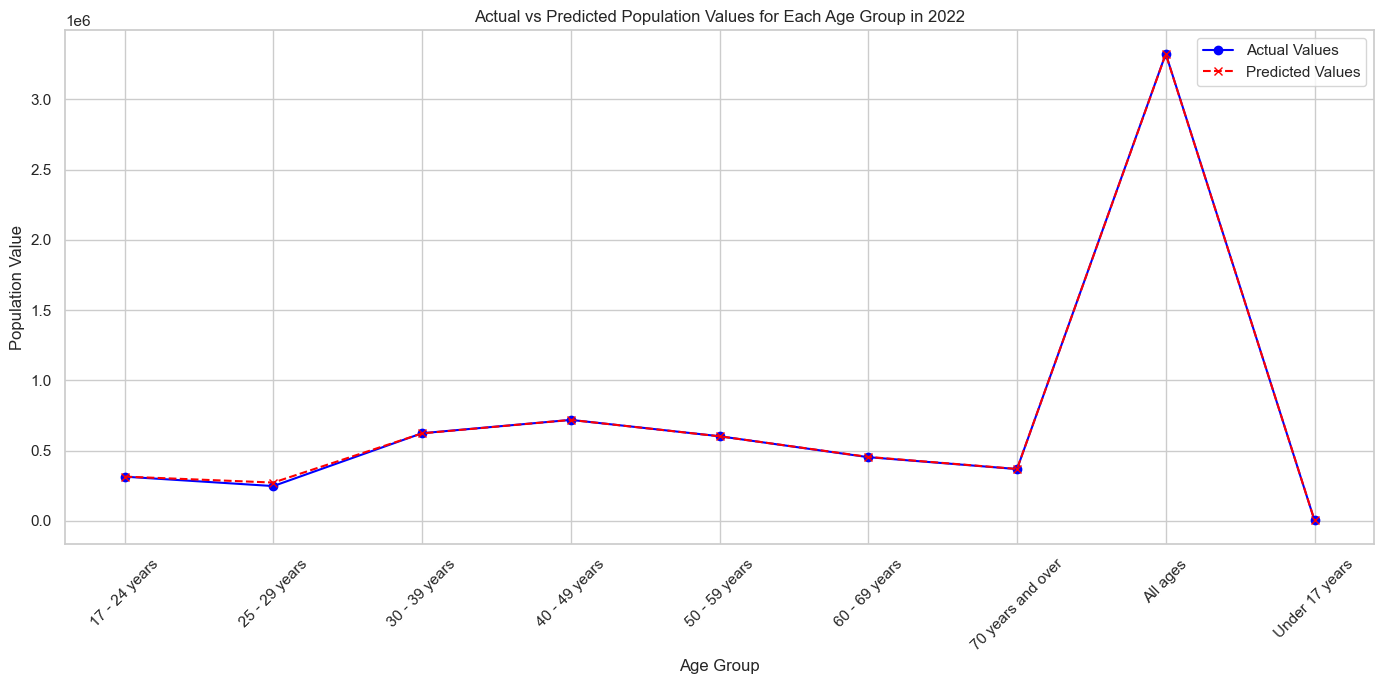

In [97]:
# 2022 yılı için gerçek verileri ve modelin tahminlerini içeren bir grafik çizdirelim.
# Öncelikle 2022 yılı için tahminleri yapalım.
X_2022 = df_GBR[df_GBR['Year'] == 2022][['Year', 'Age Group']]
X_2022['Age Group Encoded'] = label_encoder.transform(X_2022['Age Group'])
y_2022_pred = best_gbr_model.predict(X_2022[['Year', 'Age Group Encoded']])

# 2022 yılı için gerçek verileri alalım.
y_2022_actual = df_GBR[df_GBR['Year'] == 2022]['Value']

# Grafik çizdirelim.
plt.figure(figsize=(14, 7))
plt.plot(X_2022['Age Group'], y_2022_actual, label='Actual Values', color='blue', marker='o')
plt.plot(X_2022['Age Group'], y_2022_pred, label='Predicted Values', color='red', linestyle='--', marker='x')
plt.title('Actual vs Predicted Population Values for Each Age Group in 2022')
plt.xlabel('Age Group')
plt.ylabel('Population Value')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [98]:
import matplotlib.pyplot as plt
import numpy as np


# "Under 17 years" yaş grubu için yıllara göre daha önce yapılan tahminleri ve gerçek değerleri içeren bir bar plot çizdirelim.
# Creating a Dropdown widget for selecting the year
dropdown_GBR_age = widgets.Dropdown(
    options=df_GBR['Age Group'].unique(),
    description='Year:',
    disabled=False,
)

# Grafik çıktısını gösterecek bir çıktı alanı yaratın
output_GBR_age = widgets.Output()
def update_GBR_age(change):
    with output_GBR_age:
        clear_output(wait=True)  # Mevcut çıktıyı temizle
        selected_GBR_age = dropdown_GBR_age.value
        
        # "Under 17 years" yaş grubunu seçelim.
        under_17_age_group_encoded = label_encoder.transform([selected_GBR_age])[0]
        years_GBR_age = df_GBR["Year"].unique()

        # 'all_predictions' DataFrame'ini tekrar oluşturalım.
        # Yıllar ve yaş grupları için tahminleri tekrar oluşturuyoruz.
        all_predictions_df_GBR_age = []
        for year in years_GBR_age:
            year_array = np.full(shape=(1,), fill_value=year)
            age_group_encoded = label_encoder.transform([selected_GBR_age])
            predict_df_GBR_age = pd.DataFrame({
                'Year': year_array,
                'Age Group Encoded': age_group_encoded
            })
            predicted_value_GBR_age = best_gbr_model.predict(predict_df_GBR_age)
            true_value = df_GBR[(df_GBR['Year'] == year) & 
                                      (df_GBR['Age Group Encoded'] == under_17_age_group_encoded)]['Value'].values
            # Eğer o yıl için gerçek değer yoksa, tahmin değerini kullan
            true_value = true_value[0] if true_value.size > 0 else predicted_value_GBR_age[0]
            all_predictions_df_GBR_age.append((year, true_value, predicted_value_GBR_age[0]))

        # Tahminlerden oluşan bir DataFrame yaratın.
        predictions_df_GBR_age = pd.DataFrame(all_predictions_df_GBR_age, columns=['Year', 'Actual Value', 'Predicted Value GBR'])

        # Bar plot çizdirelim.
        plt.figure(figsize=(14, 7))
        width = 0.35  # Bar genişliğini tanımlayalım
        plt.bar(predictions_df_GBR_age['Year'] - width/2, predictions_df_GBR_age['Actual Value'], width, label='Actual Values', color='blue')
        plt.bar(predictions_df_GBR_age['Year'] + width/2, predictions_df_GBR_age['Predicted Value GBR'], width, label='Predicted Values GBR', color='green')

        plt.title('Actual vs Predicted Population Values for "Under 17 years" Over the Years')
        plt.xlabel('Year')
        plt.ylabel('Population Value GBR')
        plt.xticks(predictions_df_GBR_age['Year'], rotation=45)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Dropdown widget'larının değişikliklerine göre grafik güncelleme
dropdown_GBR_age.observe(update_GBR_age, names='value')

# Widget'ları ve çıktı alanını göster
display(dropdown_GBR_age, output_GBR_age)
update_GBR_age(None)  # İlk grafik

Dropdown(description='Year:', options=('17 - 24 years', '25 - 29 years', '30 - 39 years', '40 - 49 years', '50…

Output()

## Compare 

In [99]:
import matplotlib.pyplot as plt
import numpy as np


# "Under 17 years" yaş grubu için yıllara göre daha önce yapılan tahminleri ve gerçek değerleri içeren bir bar plot çizdirelim.
# Creating a Dropdown widget for selecting the year
dropdown_df_age_compare = widgets.Dropdown(
    options=df_GBR['Age Group'].unique(),
    description='Year:',
    disabled=False,
)

# Grafik çıktısını gösterecek bir çıktı alanı yaratın
output_df_age_compare = widgets.Output()
def update_df_age_compare(change):
    with output_df_age_compare:
        clear_output(wait=True)  # Mevcut çıktıyı temizle
        selected_df_age_compare = dropdown_df_age_compare.value
        
        # "Under 17 years" yaş grubunu seçelim.
        under_17_age_group_encoded = label_encoder.transform([selected_df_age_compare])[0]
        years_df_age_compare = df_GBR["Year"].unique()

        # 'all_predictions' DataFrame'ini tekrar oluşturalım.
        # Yıllar ve yaş grupları için tahminleri tekrar oluşturuyoruz.
        all_predictions_df_GBR_age_compare = []
        for year in years_df_age_compare:
            year_array = np.full(shape=(1,), fill_value=year)
            age_group_encoded = label_encoder.transform([selected_df_age_compare])
            predict_df_GBR_age_compare = pd.DataFrame({
                'Year': year_array,
                'Age Group Encoded': age_group_encoded
            })
            predicted_value_df_GBR_age_compare = best_gbr_model.predict(predict_df_GBR_age_compare)
            true_value = df_GBR[(df_GBR['Year'] == year) & 
                                      (df_GBR['Age Group Encoded'] == under_17_age_group_encoded)]['Value'].values
            # Eğer o yıl için gerçek değer yoksa, tahmin değerini kullan
            true_value = true_value[0] if true_value.size > 0 else predicted_value_df_GBR_age_compare[0]
            all_predictions_df_GBR_age_compare.append((year, true_value, predicted_value_df_GBR_age_compare[0]))

        # Tahminlerden oluşan bir DataFrame yaratın.
        predictions_df_GBR_age_compare = pd.DataFrame(all_predictions_df_GBR_age_compare, columns=['Year', 'Actual Value', 'Predicted Value GBR'])

        
        all_predictions_df_RFR_age_compare = []
        for year in years_df_age_compare:
            year_array = np.full(shape=(1,), fill_value=year)
            age_group_encoded = label_encoder.transform([selected_df_age_compare])
            predict_df_RFR_age_compare = pd.DataFrame({
                'Year': year_array,
                'Age Group Encoded': age_group_encoded
            })
            predicted_value_df_RFR_age_compare = best_rf_model.predict(predict_df_RFR_age_compare)
            all_predictions_df_RFR_age_compare.append((year, true_value, predicted_value_df_RFR_age_compare[0]))

        # Tahminlerden oluşan bir DataFrame yaratın.
        predictions_df_RFR_age_compare = pd.DataFrame(all_predictions_df_RFR_age_compare, columns=['Year', 'Actual Value', 'Predicted Value RFR'])

        
        predictions_df_compare = predictions_df_GBR_age_compare.copy()
        predictions_df_compare['Predicted Value RFR'] = predictions_df_RFR_age_compare['Predicted Value RFR'].copy()

       # Bar plot çizdirelim.
        plt.figure(figsize=(14, 7))
        width = 0.2  # Bar genişliğini tanımlayalım
        plt.bar(predictions_df_compare['Year'] - width, predictions_df_compare['Actual Value'], width, label='Actual Values', color='blue')
        plt.bar(predictions_df_compare['Year'], predictions_df_compare['Predicted Value RFR'], width, label='Predicted Values RFR', color='red')
        plt.bar(predictions_df_compare['Year'] + width, predictions_df_compare['Predicted Value GBR'], width, label='Predicted Values GBR', color='green')
        plt.title(f'Actual vs Predicted Values Random forest vs Gradient Boosting for {selected_df_age_compare} Over the Years')
        plt.xlabel('Year')
        plt.ylabel('Population Value')
        plt.xticks(predictions_df_compare['Year'], rotation=45)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Dropdown widget'larının değişikliklerine göre grafik güncelleme
dropdown_df_age_compare.observe(update_df_age_compare, names='value')

# Widget'ları ve çıktı alanını göster
display(dropdown_df_age_compare, output_df_age_compare)
update_df_age_compare(None)  # İlk grafik

Dropdown(description='Year:', options=('17 - 24 years', '25 - 29 years', '30 - 39 years', '40 - 49 years', '50…

Output()

## Sentiment Analysis

In [128]:
import praw

reddit = praw.Reddit(
    client_id='bIYyUx9pkrIdPG1hfbZjAQ',         
    client_secret='xJXIPO2MLhkciCEIkqnlzYDCXq6JtA', 
    user_agent='Current_Driving_Licences'          
)

#Learning to drive in ireland is depressional
submission_id = 't1am4z'  # Gönderinin ID'si
submission = reddit.submission(id=submission_id)

comments_list2 = []  # Yorumların saklanacağı boş liste


submission.comments.replace_more(limit=0)  # "MoreComments" öğelerini çöz
for comment in submission.comments.list():
    comments_list2.append(comment.body)
    #print(comments_list_2)

# Create a DataFrame from the comments list
comments_df2 = pd.DataFrame(comments_list2, columns=['comment'])
print(comments_df2)

                                               comment
0    I've been through what you're going through. I...
1    Best of luck with your test..it is a complete ...
2    Wow. A lot of comments here amount to the 'Fuc...
3    They don't want young people driving but they ...
4    I know you can't really be driving on the road...
..                                                 ...
96                                           [deleted]
97   I’m not sure what you want to make more afford...
98                             Never said it wasn't :)
99                Clearly never been in Donegal before
100                             They meant the county.

[101 rows x 1 columns]


In [101]:
# # Önceden oluşturduğunuz comments_list'i kullanarak
# with open("t1am4z.txt", "w", encoding="utf-8") as file:
#     for comment in comments_list:
#         file.write("%s\n\n" % comment)


In [136]:
import praw

reddit = praw.Reddit(
    client_id='bIYyUx9pkrIdPG1hfbZjAQ',         
    client_secret='xJXIPO2MLhkciCEIkqnlzYDCXq6JtA', 
    user_agent='Current_Driving_Licences'          
)

#By what age do most people hope to get their drivers license?
submission_id = 't6055k'  # Gönderinin ID'si
submission = reddit.submission(id=submission_id)

comments_list = []  # Yorumların saklanacağı boş liste

submission.comments.replace_more(limit=0)  # "MoreComments" öğelerini çöz
for comment in submission.comments.list():
    comments_list.append(comment.body)
    #print(comments_list)

# Create a DataFrame from the comments list
comments_df = pd.DataFrame(comments_list, columns=['comment'])
print(comments_df)

                                              comment
0                                           [deleted]
1   Learning to drive is expensive in Ireland and ...
2   I am 29 and am in the middle of my lessons now...
3                                           [deleted]
4   Whenever is convenient and they can afford to....
5   Im nearly 34, started the process when I was 2...
6   I'm 29 and still can't afford lessons as I'm a...
7   Depends on where they are. Dubs don't drive be...
8   Cist is the main factor, then convenience (or ...
9   I'm 29 and didn't get my license because I fee...
10  I'd say it's more economic necessity than soci...
11  Never had a need to drive so never got a license.
12  I got mine as soon as I turned 17. All of my f...
13  My nephew is 5 and Is mad to get a license and...
14  I got my provisional at 21 first car at 22 and...
15  Am I right in guessing these people live in Du...
16                          I was 37 when I got mine!
17  Why would you assume eve

In [132]:
# # Önceden oluşturduğunuz comments_list'i kullanarak
# with open("t6055k.txt", "w", encoding="utf-8") as file:
#     for comment in comments_list:
#         file.write("%s\n\n" % comment)


In [130]:
comments_df3=comments_df.copy()

In [131]:
from textblob import TextBlob
from nltk.sentiment import SentimentIntensityAnalyzer

# Assuming df is your DataFrame with the column 'comment' that contains the text
sia = SentimentIntensityAnalyzer()
comments_df3['polarity'] = comments_df3['comment'].apply(lambda x: TextBlob(x).sentiment.polarity)
comments_df3['subjectivity'] = comments_df3['comment'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
comments_df3['compound'] = comments_df3['comment'].apply(lambda x: sia.polarity_scores(x)['compound'])
comments_df3

,comment,polarity,subjectivity,compound
0,[deleted],0.000000e+00,0.000000,0.0000
1,Learning to drive is expensive in Ireland and ...,-1.666667e-01,0.516667,-0.1280
2,I am 29 and am in the middle of my lessons now...,2.333333e-01,0.280000,0.0000
3,[deleted],0.000000e+00,0.000000,0.0000
4,Whenever is convenient and they can afford to....,3.166667e-01,0.429167,-0.1833
5,"Im nearly 34, started the process when I was 2...",-8.181818e-02,0.541026,-0.6013
6,I'm 29 and still can't afford lessons as I'm a...,-3.333333e-01,1.000000,-0.3612
7,Depends on where they are. Dubs don't drive be...,-1.819444e-02,0.492083,0.4404
8,"Cist is the main factor, then convenience (or ...",2.003646e-01,0.501525,0.6001
9,I'm 29 and didn't get my license because I fee...,2.372727e-01,0.380000,-0.0602


In [140]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk
import pandas as pd

# Gerekli NLTK bileşenlerini indirin (sadece ilk kez gereklidir)
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

# Ön işleme fonksiyonu
def preprocess_text(text):
    # Küçük harfe çevirme
    text = text.lower()
    # Noktalama işaretlerini kaldırma
    text = re.sub(r'[^\w\s]', '', text)
    # Stop words kaldırma
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

# Assuming 'comments_df' is a DataFrame with a column named 'text' containing the text data.
comments_df['cleaned_comment'] = comments_df['comment'].apply(preprocess_text)
print(comments_df['cleaned_comment'])


0                                               deleted
1     learning drive expensive ireland thats probabl...
2     29 middle lesson never felt need drive lot pub...
3                                               deleted
4     whenever convenient afford people never want 2...
5     im nearly 34 started process 28 lesson test sp...
6     im 29 still cant afford lesson im pre school t...
7     depends dub dont drive public transport cyclin...
8     cist main factor convenience inconvenience nec...
9     im 29 didnt get license feel panicky car lived...
10    id say economic necessity societal pressure ma...
11                   never need drive never got license
12    got mine soon turned 17 friend probably depend...
13                  nephew 5 mad get license go driving
14    got provisional 21 first car 22 licence 24 fir...
15    right guessing people live dublin happens city...
16                                          37 got mine
17                    would assume everyone driv

In [138]:
# Assuming comments_list is a list of comment strings:
cleaned_comments = [preprocess_text(comment) for comment in comments_df]  # List comprehension to preprocess each comment

# If you need to combine all comments into a single string:
all_comments_string = ' '.join(cleaned_comments)
print(all_comments_string)


comment


Data preparation was the crucial first step I took in sentiment analysis. I started by converting the entire text to lowercase to ensure uniformity, then removed all punctuation to reduce noise in the data. Next, I got rid of any extra spaces and made sure the text didn't have any unnecessary leading or trailing spaces. After that, I tokenized the text into individual words and filtered out the common stop words that usually don't carry much meaning. In the end, I combined these words back into a single string when necessary, setting the stage for a comprehensive sentiment analysis.

In [143]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk
import pandas as pd

# Gerekli NLTK bileşenlerini indirin (sadece ilk kez gereklidir)
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

# Ön işleme fonksiyonu
def preprocess_text(text):
    # Küçük harfe çevirme
    text = text.lower()
    # Noktalama işaretlerini kaldırma
    text = re.sub(r'[^\w\s]', '', text)
    # Stop words kaldırma
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

# Assuming 'comments_df' is a DataFrame with a column named 'text' containing the text data.
comments_df['cleaned_comment'] = comments_df['comment'].apply(preprocess_text)
print(comments_df['cleaned_comment'])


0                                               deleted
1     learning drive expensive ireland thats probabl...
2     29 middle lesson never felt need drive lot pub...
3                                               deleted
4     whenever convenient afford people never want 2...
5     im nearly 34 started process 28 lesson test sp...
6     im 29 still cant afford lesson im pre school t...
7     depends dub dont drive public transport cyclin...
8     cist main factor convenience inconvenience nec...
9     im 29 didnt get license feel panicky car lived...
10    id say economic necessity societal pressure ma...
11                   never need drive never got license
12    got mine soon turned 17 friend probably depend...
13                  nephew 5 mad get license go driving
14    got provisional 21 first car 22 licence 24 fir...
15    right guessing people live dublin happens city...
16                                          37 got mine
17                    would assume everyone driv

In [117]:
# Assuming comments_list is a list of comment strings:
cleaned_comments = [preprocess_text(comment) for comment in comments_list]  # List comprehension to preprocess each comment

# If you need to combine all comments into a single string:
all_comments_string = ' '.join(cleaned_comments)
print(all_comments_string)

cleaned_text = preprocess_text(all_comments_string)
print(cleaned_text)


deleted learning drive expensive ireland thats probably main barrier 29 middle lessons never felt need drive lot public transport facilities close home work bus route almost door door learning drive get older people start depend parents etc deleted whenever convenient afford people never want 22 started drive got license 23 first full time job none siblings bothered learn get along fine without mother never learned either father 39 first started learn im nearly 34 started process 28 lessons tests spent fortune plus insurance car another fortune passed 4th attempt test last year system horrible proper made test keep paying lessons live dublin park car parking town quite bad also expensive friends started driving 30 somehow moved bit car necessity im 29 still cant afford lessons im pre school teacher wages ridiculous depends dubs dont drive public transport cycling infrastructure whereas beyond pale licence becomes necessity busses unreliable longer distances cover relatives rural cork g

I installed essential libraries for sentiment analysis: NLTK for its language processing tools and TextBlob for straightforward sentiment calculations. After setting up these libraries, I downloaded the required NLTK resources, such as tokenizers and sentiment lexicons, to fully equip my analysis environment.

In [144]:
# Install NLTK and TextBlob if you haven't already
#!pip install nltk textblob

# Import necessary libraries
import nltk
from textblob import TextBlob

# Download necessary NLTK resources
#nltk.download('punkt')  # Tokenizer models
#nltk.download('averaged_perceptron_tagger')  # For POS tagging
#nltk.download('vader_lexicon')  # For Sentiment Intensity Analyzer

I conducted the sentiment analysis itself. I used the "SentimentIntensityAnalyzer" from NLTK for its nuanced scores, and TextBlob for obtaining quick sentiment polarity and subjectivity. For each piece of preprocessed text, I fed it into these tools, collected their sentiment outputs, and stored these in a structured format. This provided me with a detailed sentiment profile for each text entry.

In [148]:
from nltk.sentiment import SentimentIntensityAnalyzer
import pandas as pd
from textblob import TextBlob


# Assuming 'comments_df' is your DataFrame with a 'cleaned_text' column
sia = SentimentIntensityAnalyzer()

# Create a new column 'sentiment_scores' in your DataFrame
comments_df['sentiment_scores'] = comments_df['cleaned_comment'].apply(lambda x: sia.polarity_scores(x))

# Now, you can access sentiment scores for each text entry in the DataFrame
comments_df

,comment,cleaned_comment,sentiment_scores
0,[deleted],deleted,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
1,Learning to drive is expensive in Ireland and ...,learning drive expensive ireland thats probabl...,"{'neg': 0.176, 'neu': 0.824, 'pos': 0.0, 'comp..."
2,I am 29 and am in the middle of my lessons now...,29 middle lesson never felt need drive lot pub...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
3,[deleted],deleted,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
4,Whenever is convenient and they can afford to....,whenever convenient afford people never want 2...,"{'neg': 0.035, 'neu': 0.858, 'pos': 0.108, 'co..."
5,"Im nearly 34, started the process when I was 2...",im nearly 34 started process 28 lesson test sp...,"{'neg': 0.131, 'neu': 0.811, 'pos': 0.058, 'co..."
6,I'm 29 and still can't afford lessons as I'm a...,im 29 still cant afford lesson im pre school t...,"{'neg': 0.185, 'neu': 0.815, 'pos': 0.0, 'comp..."
7,Depends on where they are. Dubs don't drive be...,depends dub dont drive public transport cyclin...,"{'neg': 0.0, 'neu': 0.928, 'pos': 0.072, 'comp..."
8,"Cist is the main factor, then convenience (or ...",cist main factor convenience inconvenience nec...,"{'neg': 0.059, 'neu': 0.876, 'pos': 0.065, 'co..."
9,I'm 29 and didn't get my license because I fee...,im 29 didnt get license feel panicky car lived...,"{'neg': 0.108, 'neu': 0.803, 'pos': 0.088, 'co..."


In [145]:
from nltk.sentiment import SentimentIntensityAnalyzer

# Assuming 'all_comments_string' is your preprocessed text data
sia = SentimentIntensityAnalyzer()
sentiment_scores = sia.polarity_scores(comments_df)

# For TextBlob
blob = TextBlob(comments_df)
textblob_sentiment_polarity = blob.sentiment.polarity
textblob_sentiment_subjectivity = blob.sentiment.subjectivity


AttributeError: 'DataFrame' object has no attribute 'encode'

For step four, I focused on storing and organizing the sentiment analysis results. I created a structured format, like a DataFrame or a simple list of dictionaries, to store the sentiment scores for each piece of text. This approach allowed me to efficiently organize the data for further analysis and visualization. I ensured that each entry included the original text, its sentiment score, and other relevant details like polarity and subjectivity for easier reference and comparison.

In [124]:
import pandas as pd

# Assuming sentiment_scores is a dictionary returned by NLTK's SentimentIntensityAnalyzer
# and textblob_sentiment is the polarity score from TextBlob
results = {
    "text": all_comments_string,
    "nltk_polarity": sentiment_scores['compound'],
    "textblob_polarity": textblob_sentiment_polarity,
    "textblob_subjectivity": textblob_sentiment_subjectivity
}

# Convert the results into a DataFrame for easy manipulation and visualization
df = pd.DataFrame([results])


In [125]:
df

,text,nltk_polarity,textblob_polarity,textblob_subjectivity
0,deleted learning drive expensive ireland thats...,0.9699,0.075365,0.436399


In [154]:
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

# Assuming 'comments_df' is your DataFrame with sentiment scores
sia = SentimentIntensityAnalyzer()

# Create a function to calculate sentiment scores using NLTK's SentimentIntensityAnalyzer
def calculate_sentiment_scores(text):
    sentiment_scores = sia.polarity_scores(text)
    return sentiment_scores

# Assuming 'comments_df' has a 'cleaned_text' column containing preprocessed text data
comments_df['sentiment_scores'] = comments_df['cleaned_comment'].apply(calculate_sentiment_scores)

# Create a function to calculate sentiment polarity using TextBlob
def calculate_textblob_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

# Assuming 'comments_df' has a 'cleaned_text' column containing preprocessed text data
comments_df['textblob_polarity'] = comments_df['cleaned_comment'].apply(calculate_textblob_sentiment)

# Create a DataFrame from the results
df3 = comments_df[['cleaned_comment', 'sentiment_scores', 'textblob_polarity']]
df3.columns = ['comment', 'nltk_polarity', 'textblob_polarity']
df3

,comment,nltk_polarity,textblob_polarity
0,deleted,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000000e+00
1,learning drive expensive ireland thats probabl...,"{'neg': 0.176, 'neu': 0.824, 'pos': 0.0, 'comp...",-1.666667e-01
2,29 middle lesson never felt need drive lot pub...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",5.555556e-02
3,deleted,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000000e+00
4,whenever convenient afford people never want 2...,"{'neg': 0.035, 'neu': 0.858, 'pos': 0.108, 'co...",3.166667e-01
5,im nearly 34 started process 28 lesson test sp...,"{'neg': 0.131, 'neu': 0.811, 'pos': 0.058, 'co...",-2.579545e-01
6,im 29 still cant afford lesson im pre school t...,"{'neg': 0.185, 'neu': 0.815, 'pos': 0.0, 'comp...",-3.333333e-01
7,depends dub dont drive public transport cyclin...,"{'neg': 0.0, 'neu': 0.928, 'pos': 0.072, 'comp...",-8.484848e-03
8,cist main factor convenience inconvenience nec...,"{'neg': 0.059, 'neu': 0.876, 'pos': 0.065, 'co...",1.089931e-01
9,im 29 didnt get license feel panicky car lived...,"{'neg': 0.108, 'neu': 0.803, 'pos': 0.088, 'co...",2.465909e-01
